In [1]:
# Imported Libraries
import numpy as np
import pandas as pd 
import copy
from collections import Counter
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer 
from imblearn.pipeline import Pipeline

#Sampling Libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Model Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold

# Visual Libraries
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Performance metrics libraries
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve,auc
from sklearn.model_selection import ParameterGrid

# Tensorflow
import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Lambda
from keras.losses import mse
from keras import regularizers
from keras import backend as K

from VAE import VAE_oversampling
from GAN import GAN
from CV import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Setting the random seed 
import random
seed = 42
np.random.seed(seed) 
tf.random.set_seed(42)
random.seed(seed)

In [3]:
df = pd.read_csv('creditcard.csv')
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

### Train, Validate, Test split

In [4]:
X = df.drop(['Class'], axis=1)
y = df['Class']

#Split data initially to train and remainingfor cross
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, stratify=y)

# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the validation dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")
print(f"The validation and test datasets have {sorted(Counter(y_test).items())[0][1]} records for the majority class and {sorted(Counter(y_test).items())[1][1]} records for the minority class.")

The number of records in the training dataset is 227845
The number of records in the validation dataset is 56962
The training dataset has 227451 records for the majority class and 394 records for the minority class.
The validation and test datasets have 56864 records for the majority class and 98 records for the minority class.


### Pre-processing

In [5]:
X_train_processed = copy.deepcopy(X_train)
X_test_processed = copy.deepcopy(X_test)

scaler = StandardScaler()

X_train_processed = pd.DataFrame(scaler.fit_transform(X_train_processed[:]), index=X_train_processed.index)
X_test_processed = pd.DataFrame(scaler.transform(X_test_processed[:]), index=X_test_processed.index)

In [6]:
smote = SMOTE(random_state=1)

#transform the dataset
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()

X_train_procesed_smote = pd.DataFrame(scaler.fit_transform(X_train_smote[:]), index=X_train_smote.index)
X_test_processed_smote = pd.DataFrame(scaler.transform(X_test[:]), index=X_test.index)

counter = Counter(y_train_smote)
print(counter)

Counter({0: 227451, 1: 227451})


0         1         2         3         4         5         6   \
0       1.517905  0.804127 -0.730639  0.369809 -0.949495  0.754497  2.809970   
1       0.739437  0.820353 -0.535119  0.094662 -0.661519  1.103350  2.379517   
2      -0.992186  0.264727 -0.353928  0.703672 -1.054227  0.190618  1.583831   
3       0.908824  0.866346 -0.938405  0.467938 -1.268155  0.053004  0.216667   
4      -0.614449  0.364428 -0.802583  0.607399 -1.833846  0.563914  0.336899   
...          ...       ...       ...       ...       ...       ...       ...   
454897  0.052589  0.727824 -0.011660 -0.080132 -0.018123  0.861869 -0.312609   
454898 -0.998321  0.026319  0.588275 -0.713480  0.527365 -0.707397 -1.731827   
454899 -0.083229  0.000992  0.166579  0.242283  0.395871 -0.070024  0.154148   
454900  1.494763  0.759484 -0.244942 -0.043588 -0.461805  0.592151 -0.616468   
454901  1.110710 -0.089647 -0.427463 -0.286576  0.417429  0.527266 -0.367089   

              7         8         9   ...        20        21        22  \
0       0.247564  0.171035  1.237793  ... -0.303259 -0.100732  0.256183   
1       0.507669  0.070461  0.621395  ... -0.393141 -0.115613  0.192071   
2       0.118532 -1.164774  0.600990  ...  1.066880 -1.239349  0.082347   
3       0.256662 -0.073290  0.094092  ... -0.648101 -0.186237  0.052286   
4       0.596844 -0.100066  0.580358  ... -0.439627 -0.227264 -0.179155   
...          ...       ...       ...  ...       ...       ...       ...   
454897  0.558797 -0.339350  1.246120  ... -0.576134  0.084644 -1.053100   
454898 -1.003102  0.258260 -1.144135  ...  1.257646  0.639173 -0.189684   
454899 -0.320961 -0.373470 -0.266078  ...  0.615033  0.033503  0.678181   
454900  0.584184 -0.134465  0.484536  ... -0.303617 -0.011260  0.645402   
454901  0.304376  0.053262 -0.739108  ...  0.075850  0.164752  1.012898   

              23        24        25        26        27        28        29  
0       0.320053  1.381811 -0.576005 -0.936231 -0.000043 -0.172912 -0.405783  
1       0.058046  1.411753  0.795743 -1.121425 -0.081434 -0.261168 -0.425046  
2      -0.396061 -1.636214  1.294415  1.995442 -0.042940  0.349577  0.340633  
3       0.224239 -0.902857 -0.461135 -0.425732 -0.064613 -0.246769 -0.411210  
4       0.017419 -2.434648 -0.483705 -0.386469 -0.119465 -0.249622 -0.055308  
...          ...       ...       ...       ...       ...       ...       ...  
454897  0.139572  0.079419  0.263800 -1.372630 -0.075165  0.049622 -0.431309  
454898 -0.281370  0.518983  1.831881 -1.058677  2.207930  2.354887 -0.434967  
454899 -0.248701  0.608187  0.128417  0.572206  0.690458  0.334006 -0.431926  
454900 -0.150415  0.838984  1.235519 -0.283479 -0.087055 -0.206089 -0.353160  
454901  1.556294  0.094839  1.626369  0.075425  0.872899 -0.066394  0.804026  

[454902 rows x 30 columns]

In [7]:
adasyn = ADASYN(random_state=1)

#transform the dataset
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

scaler = StandardScaler()

X_train_processed_adasyn = pd.DataFrame(scaler.fit_transform(X_train_adasyn[:]), index=X_train_adasyn.index)
X_test_processed_adasyn = pd.DataFrame(scaler.transform(X_test[:]), index=X_test.index)

counter = Counter(y_train_adasyn)
print(counter)


Counter({0: 227451, 1: 227346})


0         1         2         3         4         5         6   \
0       1.497997  0.807605 -0.720398  0.341691 -0.944587  0.754393  2.937079   
1       0.723768  0.824929 -0.513696  0.046624 -0.647632  1.131389  2.482012   
2      -0.998427  0.231709 -0.322143  0.699726 -1.052583  0.145023  1.640827   
3       0.892232  0.874033 -0.940046  0.446925 -1.273181 -0.003692  0.195488   
4      -0.622747  0.338156 -0.796456  0.596483 -1.856508  0.548435  0.322595   
...          ...       ...       ...       ...       ...       ...       ...   
454792 -0.278257 -0.317125  0.399568 -0.196122  0.480155 -0.364798 -0.688115   
454793 -0.284818 -0.356916  0.374253 -0.121287  0.366992 -0.363686 -0.724116   
454794 -0.262898 -0.846853  0.544642 -0.623471  0.664786 -0.945299 -0.699638   
454795 -0.281035 -0.520802  0.505835 -0.311495  0.593210 -0.582510 -0.773338   
454796 -0.276654 -0.568335  0.511140 -0.368583  0.619508 -0.712578 -0.666707   

              7         8         9   ...        20        21        22  \
0       0.206308  0.208965  1.240330  ... -0.319197 -0.077837  0.259790   
1       0.484809  0.096177  0.605042  ... -0.410546 -0.094942  0.190128   
2       0.068149 -1.289076  0.584012  ...  1.073298 -1.386654  0.070904   
3       0.216049 -0.065032  0.061580  ... -0.669667 -0.176123  0.038240   
4       0.580291 -0.095060  0.562748  ... -0.457791 -0.223282 -0.213236   
...          ...       ...       ...  ...       ...       ...       ...   
454792 -0.296191  0.331323 -0.620855  ...  0.091922  0.301654  0.081603   
454793 -0.257860  0.321050 -0.639772  ...  0.067365  0.320865  0.160389   
454794 -0.447104  0.586980 -1.166988  ... -0.662250  0.439691  0.018763   
454795 -0.471053  0.424449 -0.858372  ...  0.127111  0.414965  0.218519   
454796 -0.479602  0.473131 -0.834344  ... -0.016400  0.385777  0.007265   

              23        24        25        26        27        28        29  
0       0.328586  1.409703 -0.575721 -0.940515 -0.034692 -0.179536 -0.413428  
1       0.059972  1.439765  0.818295 -1.125454 -0.121485 -0.268170 -0.432411  
2      -0.405587 -1.620378  1.325063  1.987122 -0.080436  0.345193  0.322134  
3       0.230356 -0.884092 -0.458986 -0.430718 -0.103548 -0.253710 -0.418777  
4       0.018320 -2.422001 -0.481922 -0.391509 -0.162040 -0.256575 -0.068050  
...          ...       ...       ...       ...       ...       ...       ...  
454792 -0.303912  0.248796  0.293788 -0.553832  0.211994  1.623887 -0.080870  
454793 -0.304357  0.428148  0.236176 -0.636643  0.177544  1.541535 -0.063670  
454794 -0.974679  0.618515  0.085677 -0.653749 -0.654467  0.906706  0.626391  
454795 -0.340874  0.394959  0.132398 -0.528851  0.226506  1.871120  0.016437  
454796 -0.334752  0.423787  0.167608 -0.647475  0.043163  1.605852  0.170335  

[454797 rows x 30 columns]

In [8]:
# Parameters and values to tune
param_grid_svc = dict(classifier__C = [0.1, 1], classifier__kernel = ['linear', 'rbf'], classifier__gamma= ['scale', 'auto'])

## Original Dataset Results

Original applied
---------- Validation Results ---------------
Accuracy:, 0.998341 (+/- 0.000049)
Precision: 0.950000 (+/- 0.100000)
Recall: 0.043233 (+/- 0.023752)
F1 score: 0.081715 (+/- 0.043550)
ROC_AUC: 0.583597 (+/- 0.026178)
---------- Training Results -------------
Accuracy:, 0.998422 (+/- 0.000020)
Precision: 1.000000 (+/- 0.000000)
Recall: 0.087571 (+/- 0.010789)
F1 score: 0.160859 (+/- 0.018218)
ROC_AUC: 0.998974 (+/- 0.000032)

Classified 	3 out of 98 	fraud cases correctly
Misclassified 	0 out of 56864 normal cases
Accuracy: 0.9983322214809873
Precision: 1.0
Recall: 0.030612244897959183
F1 score: 0.05940594059405941
ROC_AUC: 0.5153061224489796


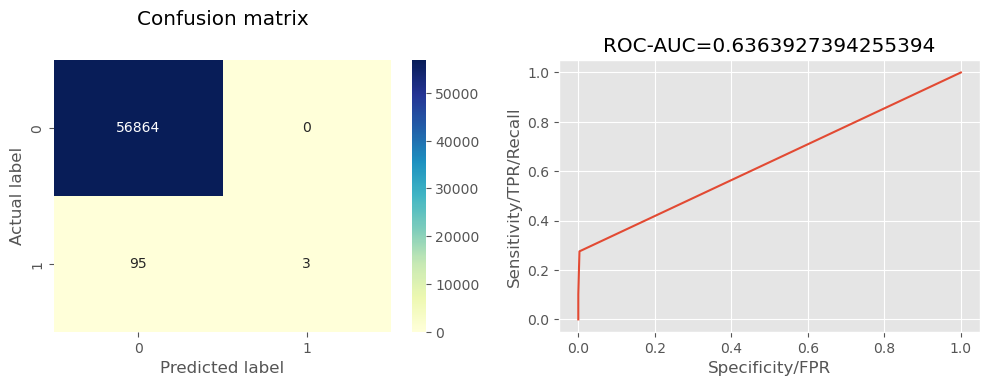

In [9]:
knn = KNeighborsClassifier()

model_cv(X_train, y_train, knn, 'original')

knn.fit(X_train, y_train)

evaluate_model(X_test, y_test, knn)

## Scaled

---------- Validation Results ---------------
Accuracy:, 0.999447 (+/- 0.000088)
Precision: 0.917467 (+/- 0.030356)
Recall: 0.748556 (+/- 0.050065)
F1 score: 0.823203 (+/- 0.031854)
ROC_AUC: 0.910945 (+/- 0.019318)
---------- Training Results -------------
Accuracy:, 0.999552 (+/- 0.000039)
Precision: 0.947090 (+/- 0.009300)
Recall: 0.784888 (+/- 0.016234)
F1 score: 0.858355 (+/- 0.013093)
ROC_AUC: 0.999901 (+/- 0.000009)

Classified 	79 out of 98 	fraud cases correctly
Misclassified 	7 out of 56864 normal cases
Accuracy: 0.9995435553526912
Precision: 0.9186046511627907
Recall: 0.8061224489795918
F1 score: 0.858695652173913
ROC_AUC: 0.9029996741240109


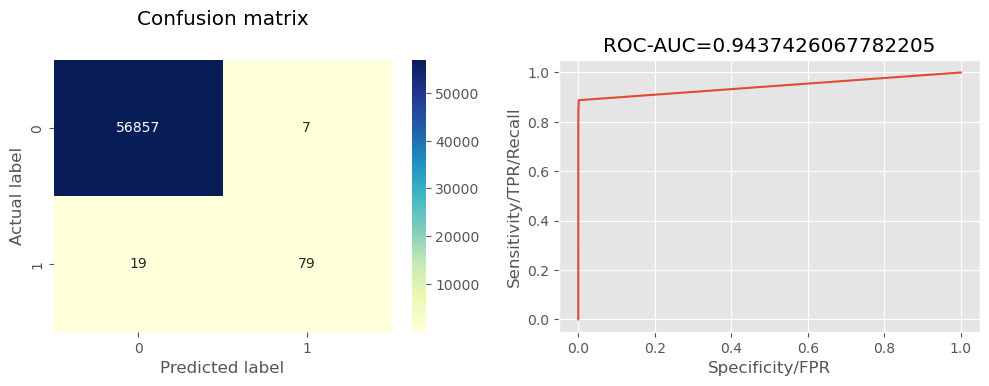

In [10]:
lr =KNeighborsClassifier()

model_cv(X_train, y_train, lr)

lr = KNeighborsClassifier()

lr.fit(X_train_processed, y_train)

train_predictions = lr.predict(X_train_processed)
print("################# Training Results ########################")
model_scores(y_train, train_predictions)

evaluate_model(X_test_processed, y_test, lr)

## With SMOTE

SMOTE applied
---------- Validation Results ---------------
Accuracy:, 0.998236 (+/- 0.000210)
Precision: 0.495402 (+/- 0.036876)
Recall: 0.796754 (+/- 0.049819)
F1 score: 0.610180 (+/- 0.037335)
ROC_AUC: 0.905556 (+/- 0.022948)
---------- Training Results -------------
Accuracy:, 0.999138 (+/- 0.000042)
Precision: 0.667403 (+/- 0.010910)
Recall: 1.000000 (+/- 0.000000)
F1 score: 0.800478 (+/- 0.007833)
ROC_AUC: 1.000000 (+/- 0.000000)

Classified 	82 out of 98 	fraud cases correctly
Misclassified 	94 out of 56864 normal cases
Accuracy: 0.9980688880306169
Precision: 0.4659090909090909
Recall: 0.8367346938775511
F1 score: 0.5985401459854014
ROC_AUC: 0.9175408134553765


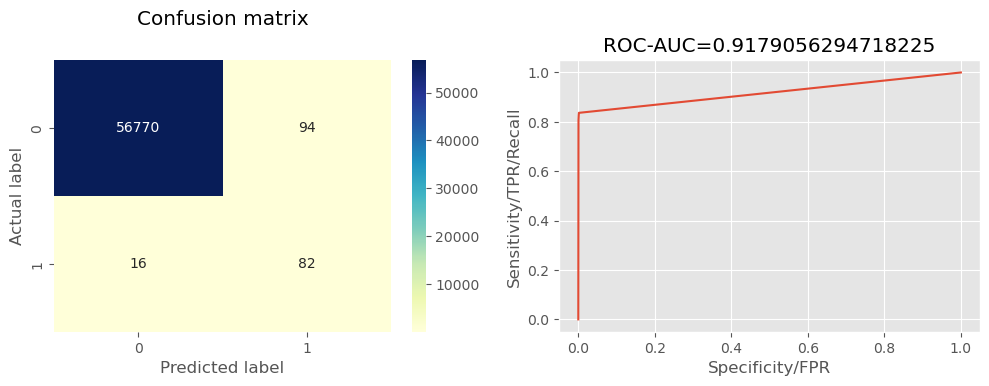

In [11]:
lr = KNeighborsClassifier()

model_cv(X_train, y_train, lr, 'smote')

lr = KNeighborsClassifier()

lr.fit(X_train_procesed_smote, y_train_smote)

train_predictions = lr.predict(X_train_procesed_smote)
print("################# Training Results ########################")
model_scores(y_train_smote, train_predictions)

evaluate_model(X_test_processed_smote, y_test, lr)

## ADASYN

ADASYN applied
---------- Validation Results ---------------
Accuracy:, 0.998275 (+/- 0.000165)
Precision: 0.501551 (+/- 0.030923)
Recall: 0.801818 (+/- 0.049634)
F1 score: 0.616595 (+/- 0.033676)
ROC_AUC: 0.906844 (+/- 0.023046)
---------- Training Results -------------
Accuracy:, 0.999152 (+/- 0.000027)
Precision: 0.670996 (+/- 0.007245)
Recall: 1.000000 (+/- 0.000000)
F1 score: 0.803087 (+/- 0.005198)
ROC_AUC: 1.000000 (+/- 0.000000)

Classified 	82 out of 98 	fraud cases correctly
Misclassified 	92 out of 56864 normal cases
Accuracy: 0.9981039991573329
Precision: 0.47126436781609193
Recall: 0.8367346938775511
F1 score: 0.6029411764705882
ROC_AUC: 0.9175583992741723


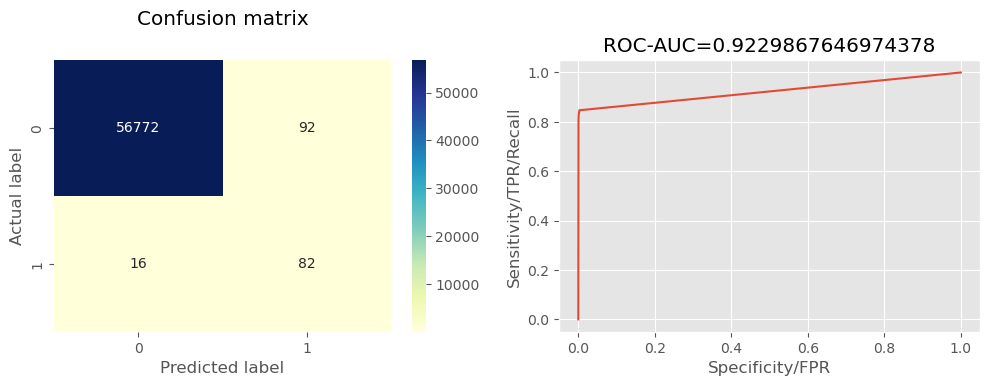

In [12]:
lr = KNeighborsClassifier()

model_cv(X_train, y_train, lr, 'adasyn')

lr = KNeighborsClassifier()

lr.fit(X_train_processed_adasyn, y_train_adasyn)

train_predictions = lr.predict(X_train_processed_adasyn)
print("################# Training Results ########################")
model_scores(y_train_adasyn, train_predictions)

evaluate_model(X_test_processed_adasyn, y_test, lr)

## Oversampling with VAE

### Hyperparameter Tuning with cross validation

############################### Parameters tested: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 2s 4ms/step - loss: 34.6701 - val_loss: 29.1231
Epoch 2/100
284/284 [==============================] - 1s 3ms/step - loss: 29.9345 - val_loss: 26.2609
Epoch 3/100
284/284 [==============================] - 1s 3ms/step - loss: 28.7334 - val_loss: 25.9735
Epoch 4/100
284/284 [==============================] - 1s 3ms/step - loss: 28.4655 - val_loss: 25.9305
Epoch 5/100
284/284 [==============================] - 1s 3ms/step - loss: 28.0678 - val_loss: 26.0238
Epoch 6/100
284/284 [==========================

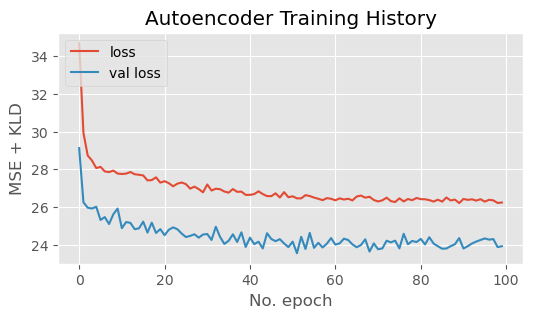

5677/5677 [==============================] - 12s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 7ms/step - loss: 34.9144 - val_loss: 28.9892
Epoch 2/100
283/283 [==============================] - 2s 5ms/step - loss: 30.2848 - val_loss: 25.9365
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 28.5376 - val_loss: 24.8687
Epoch 4/100
283/283 [==============================] - 1s 5ms/step - loss: 28.2183 - val_loss: 25.0030
Epoch 5/100
283/283 [==============================] - 1s 5ms/step - loss: 28.0882 - val_loss: 24.6777
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.8621 - val_loss: 24.9806
Epoch 7/100
283/283

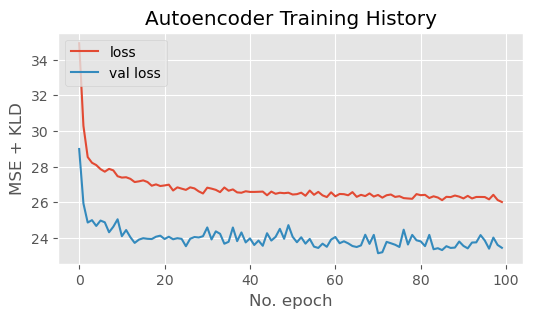

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 6ms/step - loss: 35.0524 - val_loss: 28.8591
Epoch 2/100
283/283 [==============================] - 1s 5ms/step - loss: 30.5757 - val_loss: 25.6671
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 28.6773 - val_loss: 25.0686
Epoch 4/100
283/283 [==============================] - 1s 5ms/step - loss: 28.5020 - val_loss: 24.6251
Epoch 5/100
283/283 [==============================] - 1s 5ms/step - loss: 28.1228 - val_loss: 24.2751
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1168 - val_loss: 24.2972
Epoch 7/100
283/283

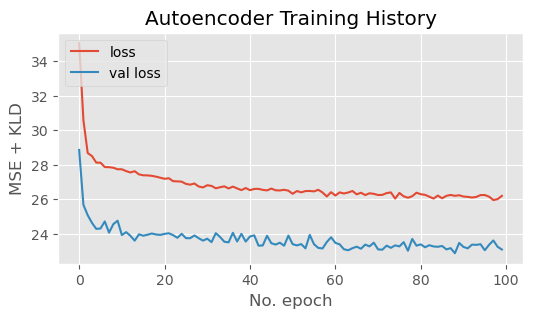

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 7ms/step - loss: 35.2215 - val_loss: 29.5793
Epoch 2/100
283/283 [==============================] - 1s 5ms/step - loss: 29.8557 - val_loss: 26.7854
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 28.3028 - val_loss: 26.2396
Epoch 4/100
283/283 [==============================] - 1s 5ms/step - loss: 28.0992 - val_loss: 26.1062
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 27.8539 - val_loss: 26.0159
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.8095 - val_loss: 25.4163
Epoch 7/100
283/283

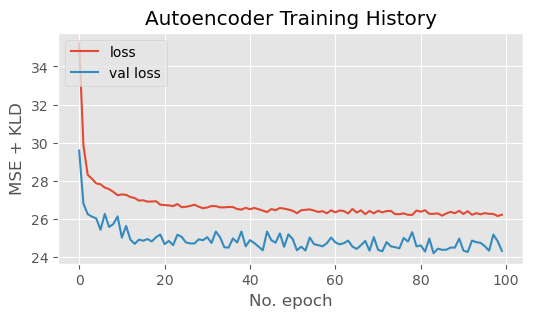

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 6ms/step - loss: 33.9504 - val_loss: 38.7430
Epoch 2/100
283/283 [==============================] - 1s 5ms/step - loss: 28.7094 - val_loss: 36.4517
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 27.3518 - val_loss: 36.0370
Epoch 4/100
283/283 [==============================] - 1s 5ms/step - loss: 26.8203 - val_loss: 35.9105
Epoch 5/100
283/283 [==============================] - 1s 5ms/step - loss: 26.5664 - val_loss: 36.0520
Epoch 6/100
283/283 [==============================] - 1s 5ms/step - loss: 26.5390 - val_loss: 35.5916
Epoch 7/100
283/283 

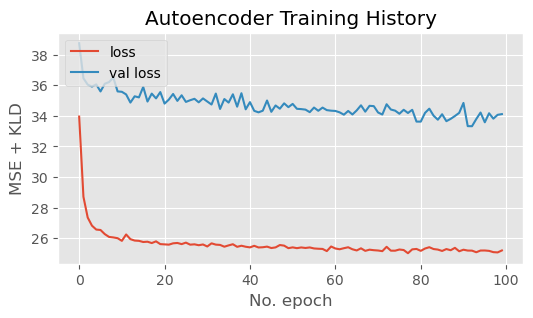

5677/5677 [==============================] - 9s 2ms/step
############################### Parameters tested: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 2s 4ms/step - loss: 34.2549 - val_loss: 29.3578
Epoch 2/100
284/284 [==============================] - 1s 3ms/step - loss: 29.8193 - val_loss: 26.2355
Epoch 3/100
284/284 [==============================] - 1s 3ms/step - loss: 28.4901 - val_loss: 26.6694
Epoch 4/100
284/284 [==============================] - 1s 3ms/step - loss: 28.2104 - val_loss: 25.6415
Epoch 5/100
284/284 [==============================] - 1s 3ms/step - loss: 27.8093 - val_loss: 2

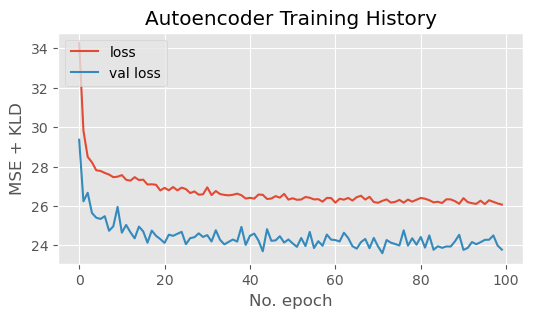

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 35.5207 - val_loss: 29.7737
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 31.0383 - val_loss: 26.1178
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.9537 - val_loss: 24.9515
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.6942 - val_loss: 25.1775
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1570 - val_loss: 24.6174
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 28.0019 - val_loss: 24.6439
Epoch 7/100
283/283

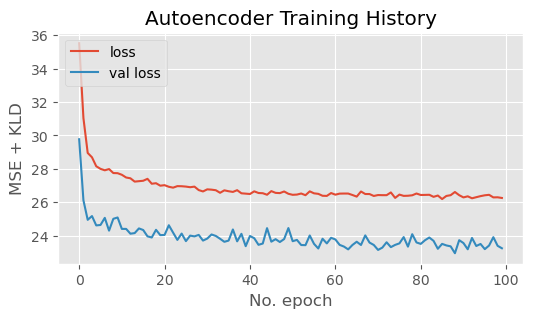

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 35.0877 - val_loss: 28.3209
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.0700 - val_loss: 25.6413
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.6286 - val_loss: 24.8698
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.6057 - val_loss: 24.7678
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1058 - val_loss: 24.3640
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 28.0253 - val_loss: 24.0857
Epoch 7/100
283/283 

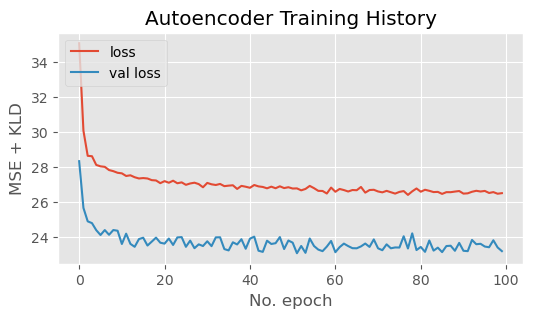

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 6ms/step - loss: 34.6343 - val_loss: 29.3406
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 29.7244 - val_loss: 26.3985
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1933 - val_loss: 25.8867
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.0556 - val_loss: 25.7937
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 27.6421 - val_loss: 25.9235
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.6007 - val_loss: 25.6440
Epoch 7/100
283/283 

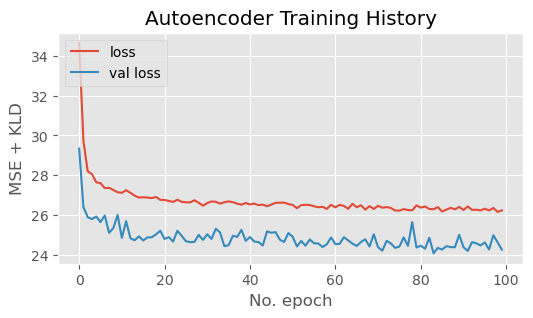

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 34.7256 - val_loss: 39.2931
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 29.6247 - val_loss: 36.9945
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 27.7185 - val_loss: 36.3766
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 27.0889 - val_loss: 35.7786
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 26.6381 - val_loss: 35.6949
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 26.7128 - val_loss: 35.2286
Epoch 7/100
283/283 

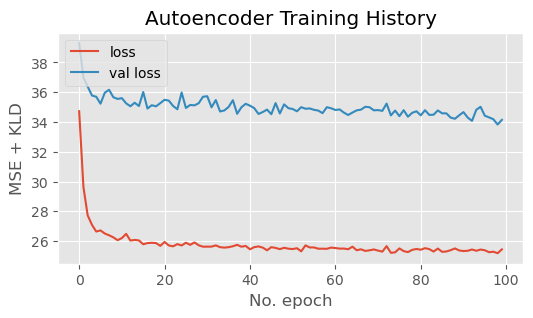

5677/5677 [==============================] - 9s 1ms/step
############################### Parameters tested: {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 2s 4ms/step - loss: 34.7163 - val_loss: 28.8417
Epoch 2/100
284/284 [==============================] - 1s 3ms/step - loss: 29.5897 - val_loss: 25.7860
Epoch 3/100
284/284 [==============================] - 1s 3ms/step - loss: 28.4026 - val_loss: 25.5380
Epoch 4/100
284/284 [==============================] - 1s 3ms/step - loss: 28.0392 - val_loss: 25.2170
Epoch 5/100
284/284 [==============================] - 1s 3ms/step - loss: 27.8695 - val_loss:

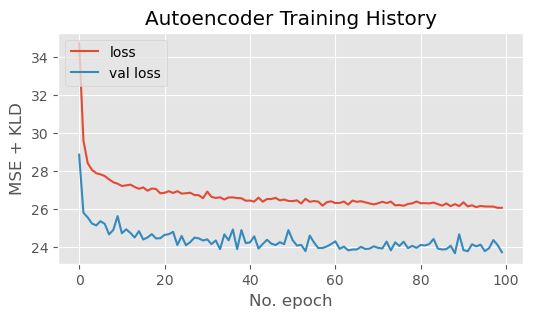

5677/5677 [==============================] - 9s 1ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 7ms/step - loss: 34.8101 - val_loss: 28.9635
Epoch 2/100
283/283 [==============================] - 1s 5ms/step - loss: 29.9809 - val_loss: 25.6046
Epoch 3/100
283/283 [==============================] - 2s 7ms/step - loss: 28.4769 - val_loss: 25.3534
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.0729 - val_loss: 24.8364
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 27.9000 - val_loss: 24.3564
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.7920 - val_loss: 25.1116
Epoch 7/100
283/283 

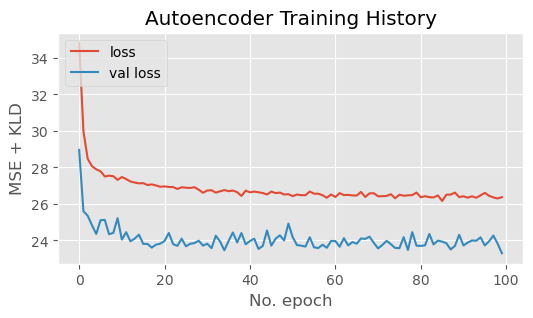

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 6ms/step - loss: 34.2591 - val_loss: 28.1209
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 29.8490 - val_loss: 24.9495
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.5344 - val_loss: 24.8215
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.5428 - val_loss: 24.4986
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1692 - val_loss: 24.2234
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1320 - val_loss: 24.2652
Epoch 7/100
283/283

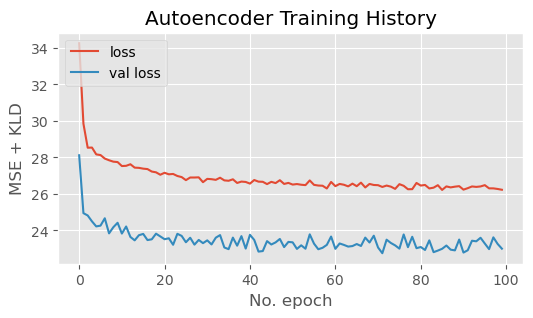

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 6ms/step - loss: 34.8617 - val_loss: 30.1210
Epoch 2/100
283/283 [==============================] - 2s 5ms/step - loss: 30.6472 - val_loss: 27.0116
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 28.8563 - val_loss: 26.3677
Epoch 4/100
283/283 [==============================] - 1s 5ms/step - loss: 28.1217 - val_loss: 26.1252
Epoch 5/100
283/283 [==============================] - 1s 5ms/step - loss: 28.0350 - val_loss: 26.1395
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.6306 - val_loss: 25.8450
Epoch 7/100
283/283

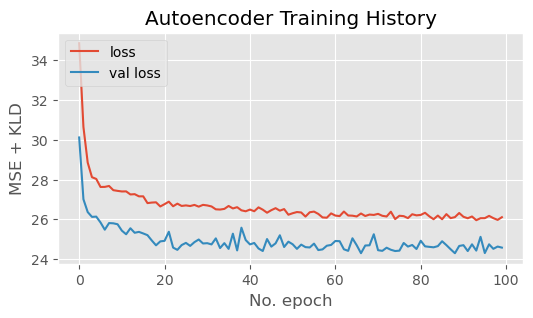

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 7ms/step - loss: 33.8891 - val_loss: 38.2519
Epoch 2/100
283/283 [==============================] - 1s 5ms/step - loss: 28.4357 - val_loss: 36.4100
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 27.2943 - val_loss: 36.0935
Epoch 4/100
283/283 [==============================] - 1s 5ms/step - loss: 26.9737 - val_loss: 35.8102
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 26.6038 - val_loss: 35.8290
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 26.5362 - val_loss: 35.7690
Epoch 7/100
283/283

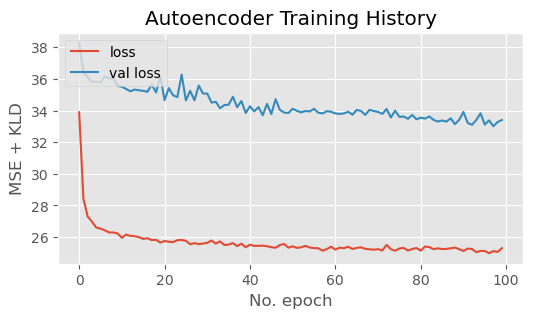

5677/5677 [==============================] - 8s 1ms/step
############################### Parameters tested: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 2s 5ms/step - loss: 34.9337 - val_loss: 28.6518
Epoch 2/100
284/284 [==============================] - 1s 4ms/step - loss: 30.0754 - val_loss: 26.0262
Epoch 3/100
284/284 [==============================] - 1s 4ms/step - loss: 28.6375 - val_loss: 25.5229
Epoch 4/100
284/284 [==============================] - 1s 4ms/step - loss: 28.2007 - val_loss: 25.3533
Epoch 5/100
284/284 [==============================] - 1s 4ms/step - loss: 27.8931 - val_loss: 25

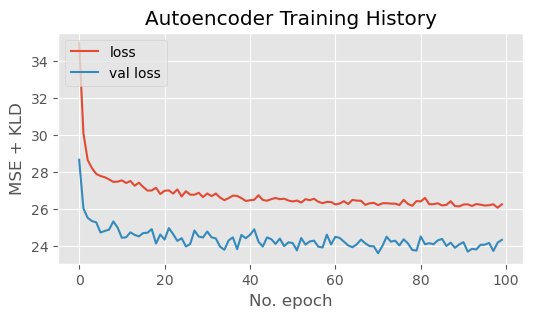

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 34.6067 - val_loss: 27.5558
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 29.8987 - val_loss: 25.5956
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.7011 - val_loss: 25.0230
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 28.2232 - val_loss: 24.6933
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 28.0377 - val_loss: 24.6054
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.8731 - val_loss: 24.3385
Epoch 7/100
283/283 

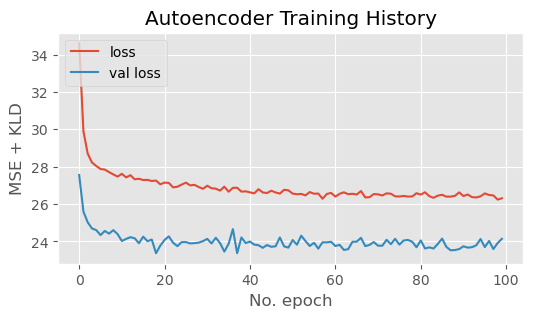

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 35.0116 - val_loss: 27.9790
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 29.9593 - val_loss: 24.9504
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.3972 - val_loss: 24.8493
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 28.2812 - val_loss: 24.3092
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 28.0866 - val_loss: 24.3685
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.9718 - val_loss: 23.9668
Epoch 7/100
283/283 

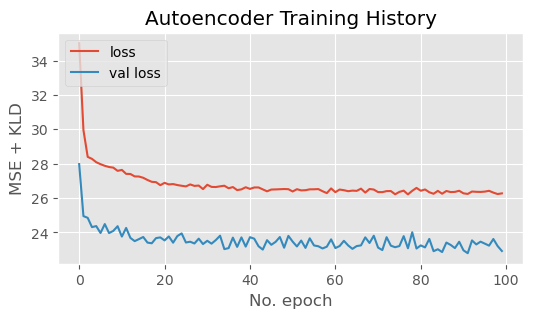

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 35.2256 - val_loss: 29.5829
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.3677 - val_loss: 26.8273
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.5649 - val_loss: 26.2759
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 28.1882 - val_loss: 26.0286
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 28.2086 - val_loss: 26.1611
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.8642 - val_loss: 25.5438
Epoch 7/100
283/283

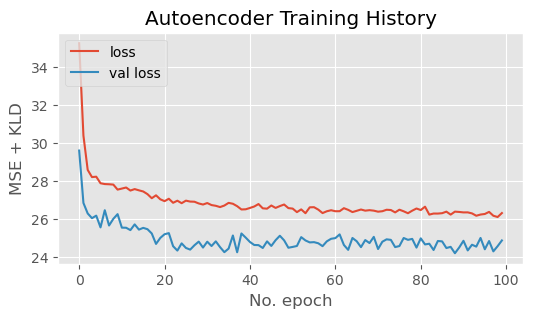

5677/5677 [==============================] - 12s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 34.3302 - val_loss: 38.8013
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 29.0191 - val_loss: 36.0504
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 27.6313 - val_loss: 35.8358
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 27.0834 - val_loss: 36.4655
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 27.0790 - val_loss: 35.6177
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 26.6735 - val_loss: 36.0113
Epoch 7/100
283/283

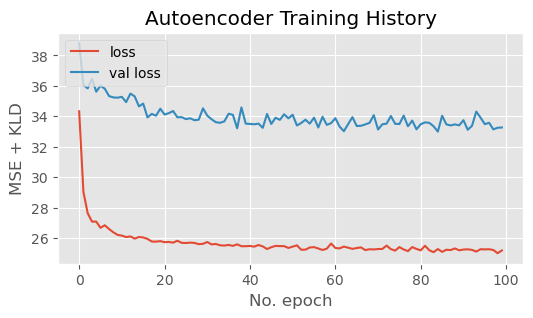

5677/5677 [==============================] - 10s 2ms/step
############################### Parameters tested: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 2s 5ms/step - loss: 34.7030 - val_loss: 29.2973
Epoch 2/100
284/284 [==============================] - 1s 3ms/step - loss: 29.8007 - val_loss: 25.8902
Epoch 3/100
284/284 [==============================] - 1s 3ms/step - loss: 28.5549 - val_loss: 26.3670
Epoch 4/100
284/284 [==============================] - 1s 3ms/step - loss: 28.2502 - val_loss: 25.6404
Epoch 5/100
284/284 [==============================] - 1s 3ms/step - loss: 27.9037 - val_loss:

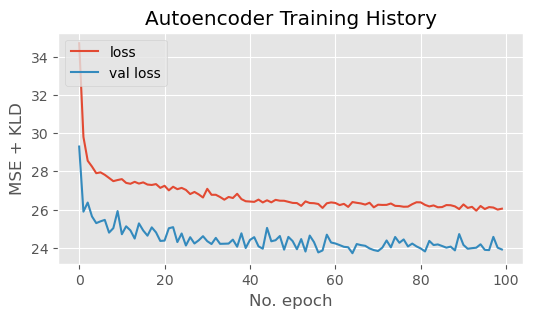

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 34.7538 - val_loss: 28.4998
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 29.9981 - val_loss: 25.3431
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.5309 - val_loss: 25.1020
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1613 - val_loss: 24.7890
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1277 - val_loss: 24.5960
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.9624 - val_loss: 24.6952
Epoch 7/100
283/283

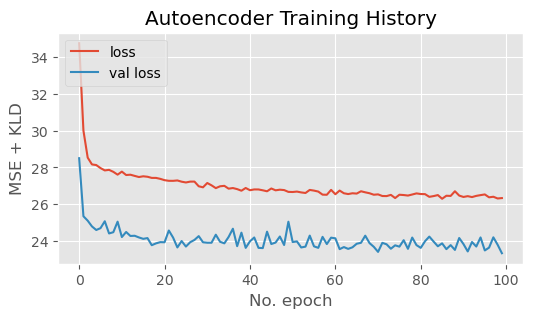

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 4s 11ms/step - loss: 34.6559 - val_loss: 28.0981
Epoch 2/100
283/283 [==============================] - 1s 5ms/step - loss: 29.8113 - val_loss: 25.1774
Epoch 3/100
283/283 [==============================] - 1s 5ms/step - loss: 28.7110 - val_loss: 24.7644
Epoch 4/100
283/283 [==============================] - 1s 5ms/step - loss: 28.7417 - val_loss: 24.6279
Epoch 5/100
283/283 [==============================] - 1s 5ms/step - loss: 28.2511 - val_loss: 24.5778
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 28.2080 - val_loss: 24.3906
Epoch 7/100
283/28

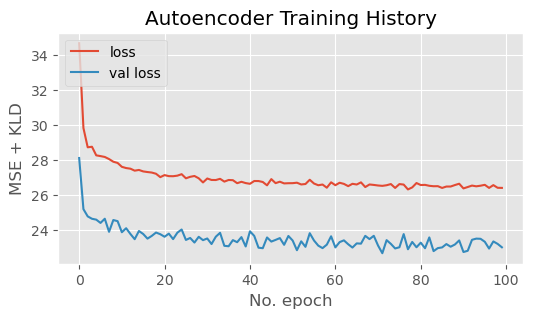

5677/5677 [==============================] - 13s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 35.1530 - val_loss: 29.9775
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 29.8718 - val_loss: 26.6116
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.6383 - val_loss: 25.9605
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.3852 - val_loss: 25.9866
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 27.7990 - val_loss: 25.6204
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.7304 - val_loss: 25.6949
Epoch 7/100
283/283

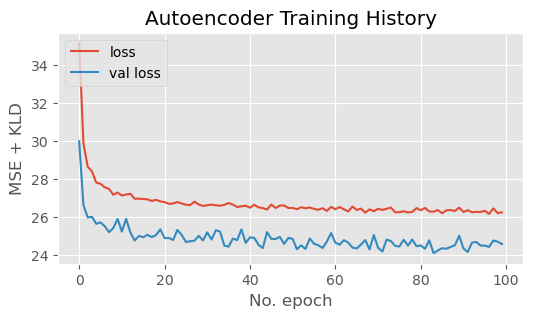

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 34.5638 - val_loss: 39.5736
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.0235 - val_loss: 37.2715
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 27.8653 - val_loss: 36.2349
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 27.4025 - val_loss: 35.9947
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 26.9532 - val_loss: 36.2897
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.0296 - val_loss: 35.9401
Epoch 7/100
283/283

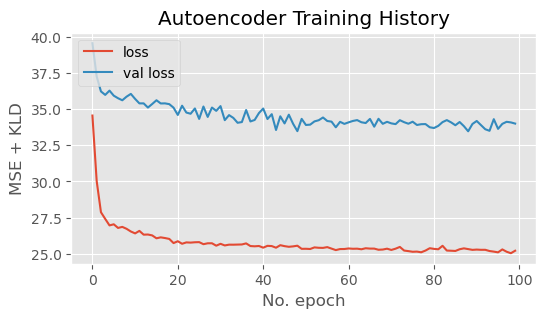

5677/5677 [==============================] - 10s 2ms/step
############################### Parameters tested: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 3s 5ms/step - loss: 35.1578 - val_loss: 29.6514
Epoch 2/100
284/284 [==============================] - 1s 4ms/step - loss: 30.3208 - val_loss: 26.3101
Epoch 3/100
284/284 [==============================] - 1s 4ms/step - loss: 28.6499 - val_loss: 25.7989
Epoch 4/100
284/284 [==============================] - 1s 4ms/step - loss: 28.3280 - val_loss: 25.5878
Epoch 5/100
284/284 [==============================] - 1s 4ms/step - loss: 27.9118 - val_loss: 25

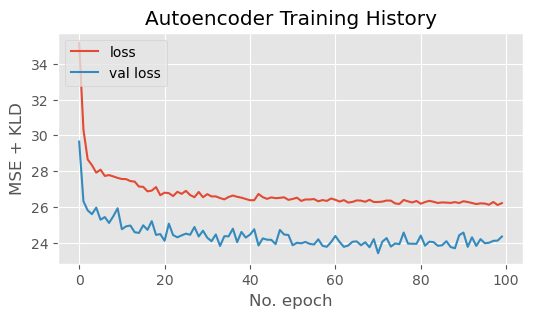

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 35.2435 - val_loss: 29.6958
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.6143 - val_loss: 26.3857
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.9727 - val_loss: 25.1366
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 28.3599 - val_loss: 24.5767
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 28.0187 - val_loss: 24.8201
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 28.0775 - val_loss: 24.4514
Epoch 7/100
283/283

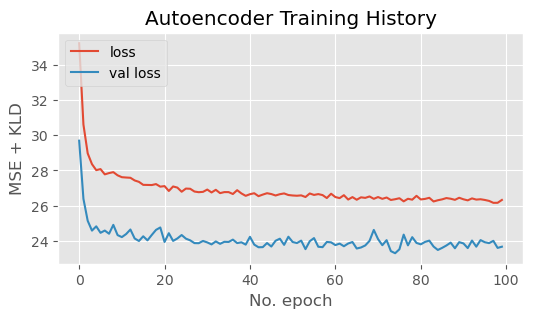

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 35.4356 - val_loss: 28.4558
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.3555 - val_loss: 25.2218
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.5267 - val_loss: 25.0791
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 28.3917 - val_loss: 24.3669
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 28.2531 - val_loss: 24.3319
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.9404 - val_loss: 23.9862
Epoch 7/100
283/283 

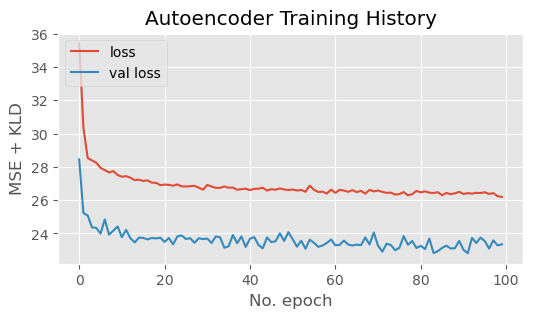

5677/5677 [==============================] - 9s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 35.2417 - val_loss: 30.0983
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.2886 - val_loss: 27.0115
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 28.8055 - val_loss: 26.0234
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 28.3562 - val_loss: 25.7388
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 27.8913 - val_loss: 26.1913
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.9487 - val_loss: 25.9927
Epoch 7/100
283/283 

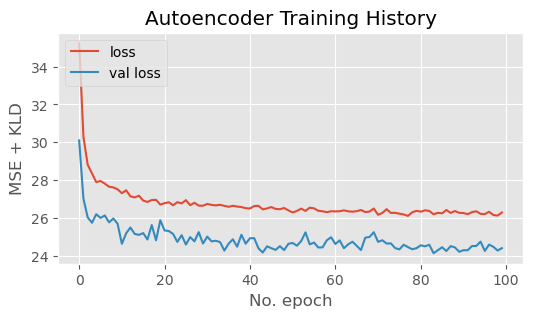

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 34.4984 - val_loss: 39.7974
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 29.9423 - val_loss: 37.2278
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 27.6532 - val_loss: 36.2505
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 27.0011 - val_loss: 35.7767
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 26.5759 - val_loss: 35.8427
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 26.5583 - val_loss: 35.8878
Epoch 7/100
283/283

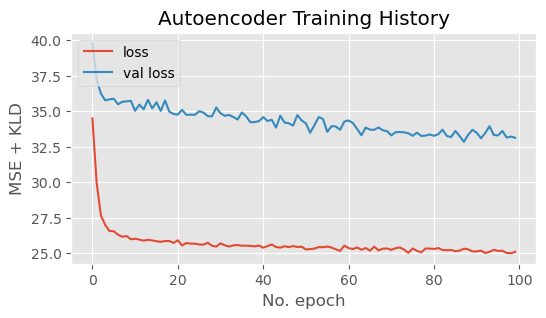

5677/5677 [==============================] - 10s 2ms/step
############################### Parameters tested: {'C': 1, 'gamma': 'auto', 'kernel': 'linear'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 2s 4ms/step - loss: 35.3966 - val_loss: 29.7401
Epoch 2/100
284/284 [==============================] - 1s 3ms/step - loss: 30.3218 - val_loss: 26.4509
Epoch 3/100
284/284 [==============================] - 1s 3ms/step - loss: 28.4970 - val_loss: 25.6525
Epoch 4/100
284/284 [==============================] - 1s 3ms/step - loss: 28.2481 - val_loss: 25.6873
Epoch 5/100
284/284 [==============================] - 1s 3ms/step - loss: 28.1201 - val_loss: 

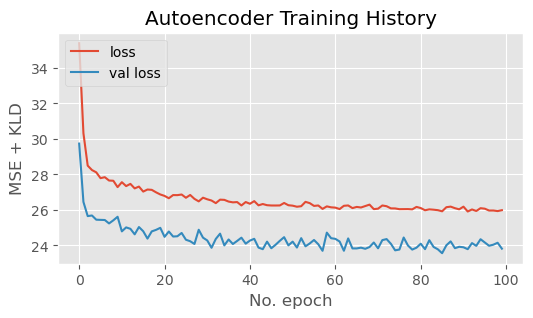

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 35.2452 - val_loss: 28.9034
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 30.2283 - val_loss: 25.7349
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.7632 - val_loss: 25.2904
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.5511 - val_loss: 25.1630
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1698 - val_loss: 24.9277
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 28.2412 - val_loss: 24.8467
Epoch 7/100
283/283

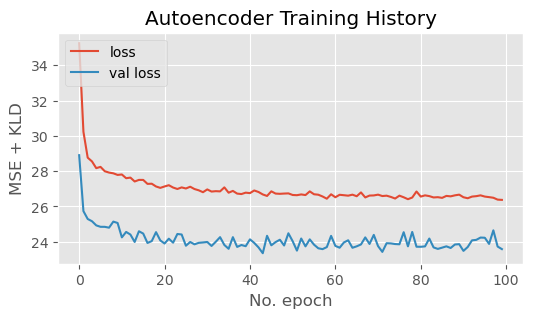

5677/5677 [==============================] - 12s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 35.4612 - val_loss: 28.7005
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.2425 - val_loss: 25.3061
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.7667 - val_loss: 25.1145
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 28.6493 - val_loss: 24.4611
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 27.9960 - val_loss: 24.0321
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 28.0446 - val_loss: 24.3938
Epoch 7/100
283/283

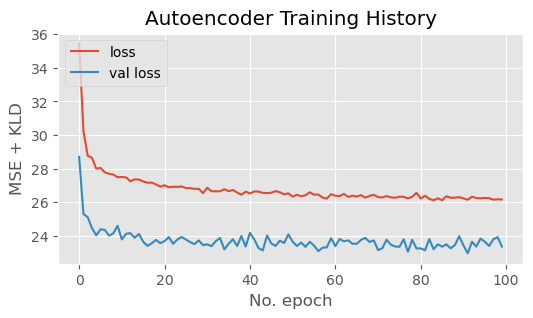

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 5ms/step - loss: 35.1139 - val_loss: 29.2485
Epoch 2/100
283/283 [==============================] - 1s 5ms/step - loss: 29.9002 - val_loss: 26.8695
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.4669 - val_loss: 26.1888
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 27.9186 - val_loss: 25.7551
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 28.0315 - val_loss: 25.7557
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.5094 - val_loss: 25.2411
Epoch 7/100
283/283

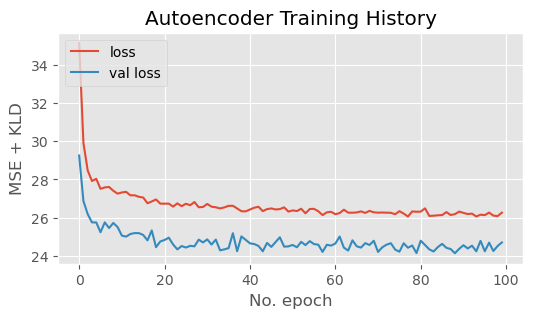

5677/5677 [==============================] - 13s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 34.4626 - val_loss: 39.2074
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 29.1639 - val_loss: 36.4864
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 27.4752 - val_loss: 36.0847
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 26.8751 - val_loss: 36.2114
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 26.6748 - val_loss: 35.5406
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 26.5012 - val_loss: 36.3456
Epoch 7/100
283/283

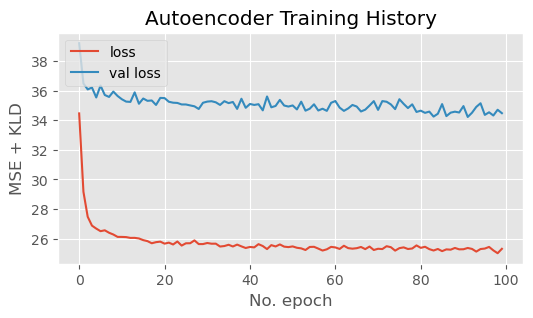

5677/5677 [==============================] - 10s 2ms/step
############################### Parameters tested: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Epoch 1/100
284/284 [==============================] - 2s 5ms/step - loss: 35.3641 - val_loss: 30.3064
Epoch 2/100
284/284 [==============================] - 1s 3ms/step - loss: 30.7636 - val_loss: 26.5527
Epoch 3/100
284/284 [==============================] - 1s 3ms/step - loss: 28.9748 - val_loss: 25.7751
Epoch 4/100
284/284 [==============================] - 1s 3ms/step - loss: 28.5033 - val_loss: 25.8679
Epoch 5/100
284/284 [==============================] - 1s 3ms/step - loss: 28.0704 - val_loss: 25.

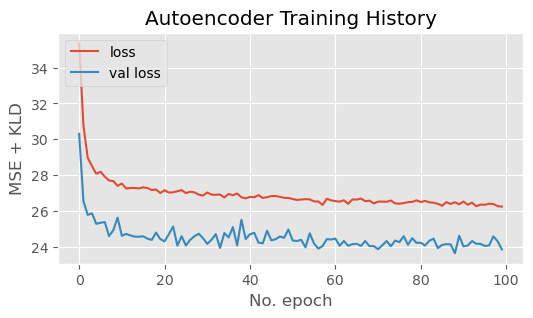

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 3s 6ms/step - loss: 34.6635 - val_loss: 27.2498
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 29.6291 - val_loss: 25.4348
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.5815 - val_loss: 24.9955
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.0998 - val_loss: 24.6783
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1168 - val_loss: 24.7405
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.7765 - val_loss: 24.1554
Epoch 7/100
283/283

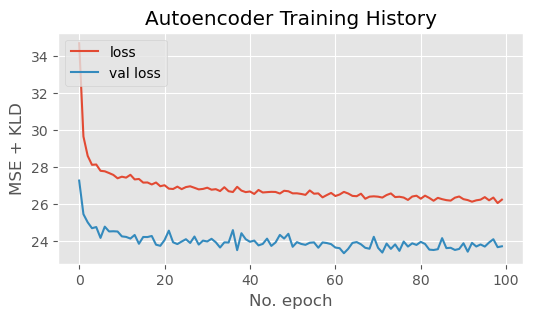

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 35.2570 - val_loss: 28.1359
Epoch 2/100
283/283 [==============================] - 1s 4ms/step - loss: 30.3607 - val_loss: 25.3245
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.6938 - val_loss: 24.8541
Epoch 4/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1781 - val_loss: 24.6652
Epoch 5/100
283/283 [==============================] - 1s 4ms/step - loss: 28.1310 - val_loss: 24.4945
Epoch 6/100
283/283 [==============================] - 1s 4ms/step - loss: 27.8493 - val_loss: 23.8977
Epoch 7/100
283/283

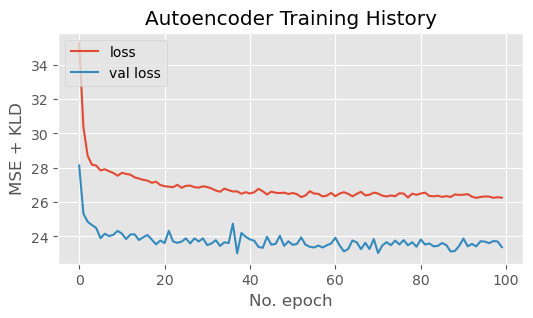

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 5ms/step - loss: 35.3849 - val_loss: 29.5866
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 30.2900 - val_loss: 26.7515
Epoch 3/100
283/283 [==============================] - 1s 4ms/step - loss: 28.5567 - val_loss: 25.8918
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 27.9854 - val_loss: 25.7336
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 27.9921 - val_loss: 25.8407
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 27.6547 - val_loss: 25.4044
Epoch 7/100
283/283

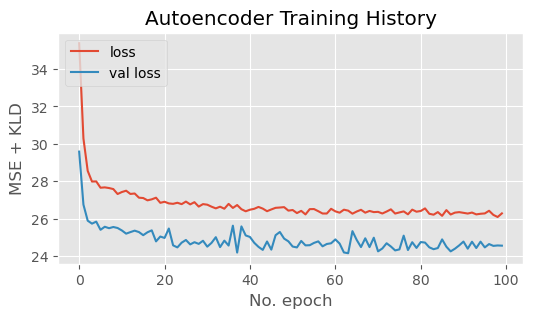

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Epoch 1/100
283/283 [==============================] - 2s 4ms/step - loss: 34.4904 - val_loss: 39.2272
Epoch 2/100
283/283 [==============================] - 1s 3ms/step - loss: 29.2603 - val_loss: 37.0879
Epoch 3/100
283/283 [==============================] - 1s 3ms/step - loss: 27.3900 - val_loss: 36.0542
Epoch 4/100
283/283 [==============================] - 1s 3ms/step - loss: 27.0070 - val_loss: 35.6608
Epoch 5/100
283/283 [==============================] - 1s 3ms/step - loss: 26.5400 - val_loss: 36.1148
Epoch 6/100
283/283 [==============================] - 1s 3ms/step - loss: 26.4903 - val_loss: 35.8511
Epoch 7/100
283/283

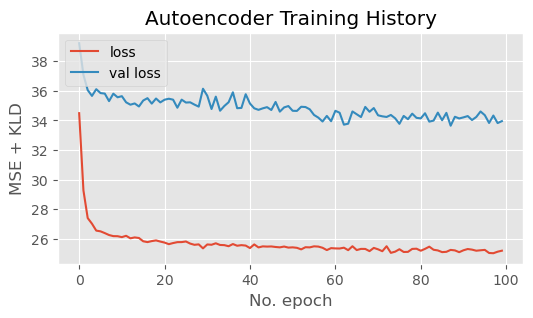

5677/5677 [==============================] - 10s 2ms/step
Accuracy:, 0.999390 (+/- 0.000038)
Precision: 0.854359 (+/- 0.020284)
Recall: 0.781564 (+/- 0.038215)
F1 score: 0.815416 (+/- 0.016631)
ROC_AUC: 0.890666 (+/- 0.019089)
Best hyperparameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}


In [13]:
#With hyperparameter tuning
#Cross validation
skf = StratifiedKFold(n_splits=5)

# Define the hyperparameters to tune
param_grid = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize variables to store the best hyperparameters and AUC score
best_params = {}
best_scores = []
best_f1 = -np.inf

# Iterate over all combinations of hyperparameters
for params in ParameterGrid(param_grid):
    lst_accuracy = []
    lst_precision = []
    lst_recall = []
    lst_f1_score = []
    lst_roc_auc_score = []
    
    f1_scores = []

    model = SVC(C=params['C'], kernel=params['kernel'], gamma=params['gamma'])

    print("############################### Parameters tested:", params,"################################")
    for count, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
        print("------------------------ KFold:", count+1, "---------------------------")
        X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

        print(f"The training dataset has {sorted(Counter(y_train_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_train_fold).items())[1][1]} records for the minority class.")
        print(f"The test dataset has {sorted(Counter(y_valid_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_valid_fold).items())[1][1]} records for the minority class.")
        
        maj = len(y_train_fold[y_train_fold == 0])
        mino = len(y_train_fold[y_train_fold == 1])
        frac = 0.5
        num_samples = round(1/(1/frac - 1) * maj - mino)

        print("Number of samples to be generated: ", num_samples)

        # Variational Oversampling 
        vos = VAE_oversampling(hidden_dim= 64,
                                latent_dim=2,
                                original_dim=30,
                                minority_class_id=1,
                                epochs=100,
                                batch_size=1,
                                num_samples_to_generate = num_samples,
                                random_state = 0,
                                optimizer="adam")
        
  

        #Fit the VAE oversampling model and get new data set
        X_res_val,y_res_val = vos.fit_sample(X_train_fold,y_train_fold)
        
        std = StandardScaler()

        X_train_processed = std.fit_transform(X_res_val) 
        X_valid_processed = std.transform(X_valid_fold)

        model.fit(X_train_processed, y_res_val)

        y_pred_test = model.predict(X_valid_processed)

        lst_accuracy.append(accuracy_score(y_valid_fold, y_pred_test))
        lst_precision.append(precision_score(y_valid_fold, y_pred_test))
        lst_recall.append(recall_score(y_valid_fold, y_pred_test))
        lst_f1_score.append(f1_score(y_valid_fold, y_pred_test))
        lst_roc_auc_score.append(roc_auc_score(y_valid_fold, y_pred_test))


    avg_f1 = np.mean(lst_f1_score)

    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_scores = [lst_accuracy, lst_precision, lst_recall, lst_f1_score, lst_roc_auc_score]
        best_params = params

# Print the best AUC score and hyperparameters
print(f"Accuracy:, {np.mean(best_scores[0]):0.6f} (+/- {np.std(best_scores[0]):0.6f})")
print(f"Precision: {np.mean(best_scores[1]):0.6f} (+/- {np.std(best_scores[1]):0.6f})")
print(f"Recall: {np.mean(best_scores[2]):0.6f} (+/- {np.std(best_scores[2]):0.6f})")
print(f"F1 score: {np.mean(best_scores[3]):0.6f} (+/- {np.std(best_scores[3]):0.6f})")
print(f"ROC_AUC: {np.mean(best_scores[4]):0.6f} (+/- {np.std(best_scores[4]):0.6f})")
print("Best hyperparameters:", best_params)


### Cross Validation

------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
NUmber of samples to be generated:  181644
Epoch 1/200
284/284 [==============================] - 3s 6ms/step - loss: 33.1874 - val_loss: 28.8385
Epoch 2/200
284/284 [==============================] - 1s 5ms/step - loss: 29.6859 - val_loss: 26.1279
Epoch 3/200
284/284 [==============================] - 1s 4ms/step - loss: 28.9176 - val_loss: 26.6385
Epoch 4/200
284/284 [==============================] - 1s 5ms/step - loss: 28.7509 - val_loss: 25.8203
Epoch 5/200
284/284 [==============================] - 1s 4ms/step - loss: 28.4855 - val_loss: 25.9837
Epoch 6/200
284/284 [==============================] - 1s 4ms/step - loss: 28.3301 - val_loss: 26.0115
Epoch 7/200
284/284 [==============================] - 1s 4ms/step - loss: 28

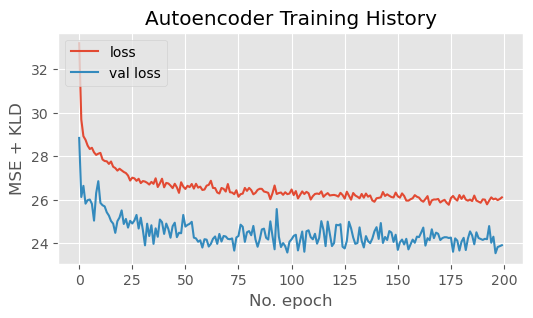

5677/5677 [==============================] - 18s 3ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Epoch 1/200
283/283 [==============================] - 2s 5ms/step - loss: 32.5131 - val_loss: 27.4778
Epoch 2/200
283/283 [==============================] - 1s 4ms/step - loss: 29.7727 - val_loss: 25.3298
Epoch 3/200
283/283 [==============================] - 1s 4ms/step - loss: 29.1089 - val_loss: 25.8874
Epoch 4/200
283/283 [==============================] - 1s 4ms/step - loss: 28.8961 - val_loss: 25.0027
Epoch 5/200
283/283 [==============================] - 1s 4ms/step - loss: 28.6283 - val_loss: 25.4356
Epoch 6/200
283/283 [==============================] - 1s 4ms/step - loss: 28.3758 - val_loss: 25.0270
Epoch 7/200
283/283

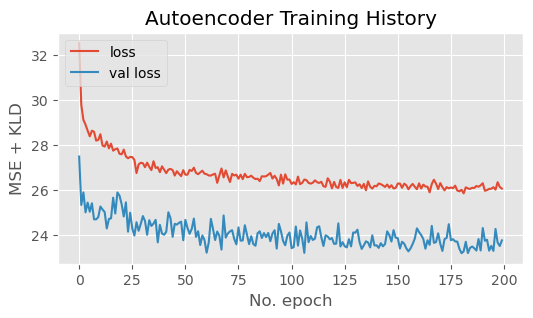

5677/5677 [==============================] - 20s 3ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Epoch 1/200
283/283 [==============================] - 6s 14ms/step - loss: 32.9574 - val_loss: 27.2589
Epoch 2/200
283/283 [==============================] - 2s 6ms/step - loss: 29.7982 - val_loss: 25.5708
Epoch 3/200
283/283 [==============================] - 2s 6ms/step - loss: 29.1075 - val_loss: 24.8853
Epoch 4/200
283/283 [==============================] - 2s 6ms/step - loss: 28.9676 - val_loss: 24.9539
Epoch 5/200
283/283 [==============================] - 2s 6ms/step - loss: 28.7442 - val_loss: 24.5100
Epoch 6/200
283/283 [==============================] - 2s 6ms/step - loss: 28.7006 - val_loss: 24.9490
Epoch 7/200
283/28

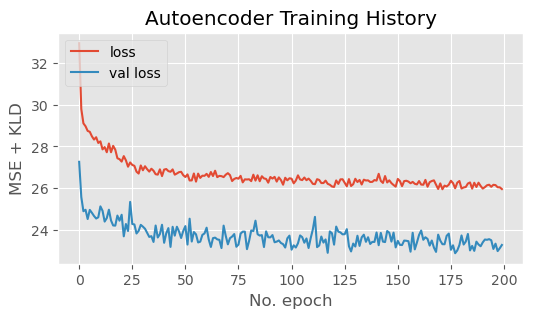

5677/5677 [==============================] - 18s 3ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Epoch 1/200
283/283 [==============================] - 4s 8ms/step - loss: 32.9645 - val_loss: 28.6597
Epoch 2/200
283/283 [==============================] - 2s 6ms/step - loss: 29.6058 - val_loss: 26.8930
Epoch 3/200
283/283 [==============================] - 1s 5ms/step - loss: 28.8208 - val_loss: 26.4989
Epoch 4/200
283/283 [==============================] - 2s 6ms/step - loss: 28.5816 - val_loss: 26.4498
Epoch 5/200
283/283 [==============================] - 2s 6ms/step - loss: 28.4308 - val_loss: 26.1850
Epoch 6/200
283/283 [==============================] - 2s 6ms/step - loss: 28.1514 - val_loss: 26.4165
Epoch 7/200
283/283

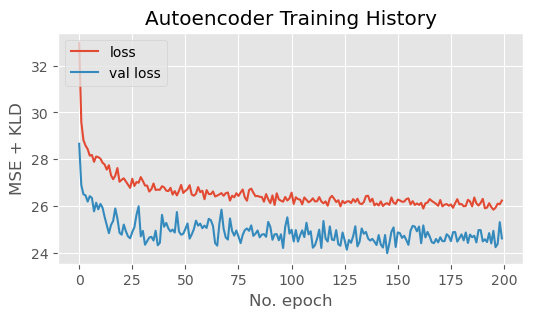

5677/5677 [==============================] - 18s 3ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Epoch 1/200
283/283 [==============================] - 2s 5ms/step - loss: 31.7154 - val_loss: 36.9895
Epoch 2/200
283/283 [==============================] - 1s 4ms/step - loss: 28.3006 - val_loss: 36.8736
Epoch 3/200
283/283 [==============================] - 1s 4ms/step - loss: 27.5577 - val_loss: 36.0928
Epoch 4/200
283/283 [==============================] - 1s 4ms/step - loss: 27.5293 - val_loss: 36.9571
Epoch 5/200
283/283 [==============================] - 1s 4ms/step - loss: 27.3937 - val_loss: 36.7952
Epoch 6/200
283/283 [==============================] - 1s 4ms/step - loss: 27.2999 - val_loss: 36.8794
Epoch 7/200
283/283

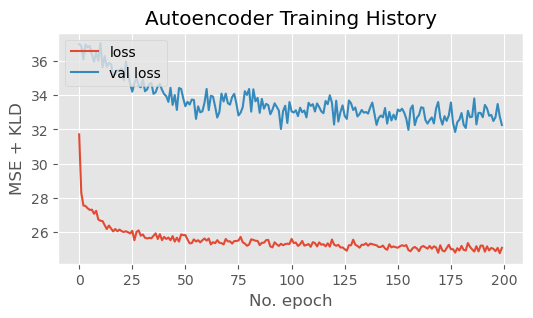

5677/5677 [==============================] - 20s 4ms/step


In [9]:
#Cross validation
skf = StratifiedKFold(n_splits=5)
lst_accuracy = []
lst_precision = []
lst_recall = []
lst_f1_score = []
lst_roc_auc_score = []


lst_accuracy_train = []
lst_precision_train = []
lst_recall_train = []
lst_f1_score_train = []
lst_roc_auc_score_train = []

model = KNeighborsClassifier()

for count, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
    print("------------------------ KFold:", count+1, "---------------------------")
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

    print(f"The training dataset has {sorted(Counter(y_train_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_train_fold).items())[1][1]} records for the minority class.")
    print(f"The test dataset has {sorted(Counter(y_valid_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_valid_fold).items())[1][1]} records for the minority class.")
    
    maj = len(y_train_fold[y_train_fold == 0])
    mino = len(y_train_fold[y_train_fold == 1])
    frac = 0.5
    num_samples = round(1/(1/frac - 1) * maj - mino)

    print("NUmber of samples to be generated: ", num_samples)

    # Variational Oversampling 
    vos = VAE_oversampling(hidden_dim=256,
                            latent_dim=20,
                            original_dim=30,
                            minority_class_id=1,
                            epochs=100,
                            batch_size=1,
                            num_samples_to_generate = num_samples,
                            random_state = 0,
                            optimizer="adam")

    #Fit the VAE oversampling model and get new data set
    X_res_val,y_res_val = vos.fit_sample(X_train_fold,y_train_fold)
    
    std = StandardScaler()
    
    X_train_processed = std.fit_transform(X_res_val) 
    X_valid_processed = std.transform(X_valid_fold)

    model.fit(X_train_processed, y_res_val)

    train_predictions = model.predict(X_train_processed)

    y_pred_test = model.predict(X_valid_processed)

    lst_accuracy.append(accuracy_score(y_valid_fold, y_pred_test))
    lst_precision.append(precision_score(y_valid_fold, y_pred_test))
    lst_recall.append(recall_score(y_valid_fold, y_pred_test))
    lst_f1_score.append(f1_score(y_valid_fold, y_pred_test))
    lst_roc_auc_score.append(roc_auc_score(y_valid_fold, y_pred_test))

    lst_accuracy_train.append(accuracy_score(y_res_val, train_predictions))
    lst_precision_train.append(precision_score(y_res_val, train_predictions))
    lst_recall_train.append(recall_score(y_res_val, train_predictions))
    lst_f1_score_train.append(f1_score(y_res_val, train_predictions))
    lst_roc_auc_score_train.append(roc_auc_score(y_res_val, train_predictions))



In [10]:
print(f"Accuracy:, {np.mean(lst_accuracy):0.6f} (+/- {np.std(lst_accuracy):0.6f})")
print(f"Precision: {np.mean(lst_precision):0.6f} (+/- {np.std(lst_precision):0.6f})")
print(f"Recall: {np.mean(lst_recall):0.6f} (+/- {np.std(lst_recall):0.6f})")
print(f"F1 score: {np.mean(lst_f1_score):0.6f} (+/- {np.std(lst_f1_score):0.6f})")
print(f"ROC_AUC: {np.mean(lst_roc_auc_score):0.6f} (+/- {np.std(lst_roc_auc_score):0.6f})")

print('############ Training #############')
print(f"Accuracy:, {np.mean(lst_accuracy_train):0.6f} (+/- {np.std(lst_accuracy_train):0.6f})")
print(f"Precision: {np.mean(lst_precision_train):0.6f} (+/- {np.std(lst_precision_train):0.6f})")
print(f"Recall: {np.mean(lst_recall_train):0.6f} (+/- {np.std(lst_recall_train):0.6f})")
print(f"F1 score: {np.mean(lst_f1_score_train):0.6f} (+/- {np.std(lst_f1_score_train):0.6f})")
print(f"ROC_AUC: {np.mean(lst_roc_auc_score_train):0.6f} (+/- {np.std(lst_roc_auc_score_train):0.6f})")

Accuracy:, 0.999364 (+/- 0.000046)
Precision: 0.924603 (+/- 0.033816)
Recall: 0.690198 (+/- 0.038698)
F1 score: 0.788992 (+/- 0.019906)
ROC_AUC: 0.845048 (+/- 0.019331)
############ Training #############
Accuracy:, 0.999724 (+/- 0.000012)
Precision: 0.999936 (+/- 0.000015)
Recall: 0.999511 (+/- 0.000026)
F1 score: 0.999724 (+/- 0.000012)
ROC_AUC: 0.999724 (+/- 0.000012)


Epoch 1/100
354/354 [==============================] - 2s 4ms/step - loss: 32.5126 - val_loss: 24.7584
Epoch 2/100
354/354 [==============================] - 2s 5ms/step - loss: 29.3904 - val_loss: 24.5777
Epoch 3/100
354/354 [==============================] - 3s 10ms/step - loss: 29.0129 - val_loss: 24.9974
Epoch 4/100
354/354 [==============================] - 2s 7ms/step - loss: 29.0075 - val_loss: 24.2266
Epoch 5/100
354/354 [==============================] - 2s 6ms/step - loss: 28.7858 - val_loss: 24.3402
Epoch 6/100
354/354 [==============================] - 2s 6ms/step - loss: 28.8196 - val_loss: 24.5673
Epoch 7/100
354/354 [==============================] - 2s 5ms/step - loss: 28.3628 - val_loss: 24.2970
Epoch 8/100
354/354 [==============================] - 2s 5ms/step - loss: 28.4151 - val_loss: 24.5202
Epoch 9/100
354/354 [==============================] - 2s 5ms/step - loss: 28.0966 - val_loss: 23.5277
Epoch 10/100
354/354 [==============================] - 2s 5ms/step - lo

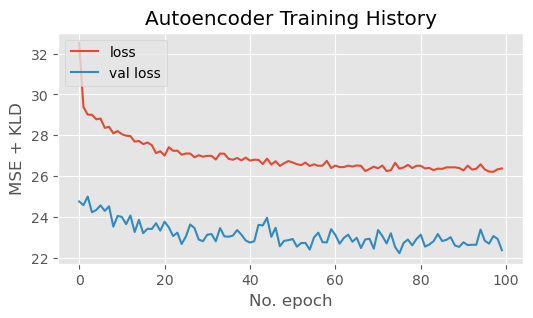

7096/7096 [==============================] - 15s 2ms/step
################# Training Results ########################
Accuracy: 0.9997274138166022
Precision: 0.9999428201959069
Recall: 0.9995119828006911
F1 score: 0.9997273550804303
ROC_AUC: 0.9997274138166022

Classified 	71 out of 98 	fraud cases correctly
Misclassified 	5 out of 56864 normal cases
Accuracy: 0.9994382219725431
Precision: 0.9342105263157895
Recall: 0.7244897959183674
F1 score: 0.8160919540229886
ROC_AUC: 0.8622009334121944


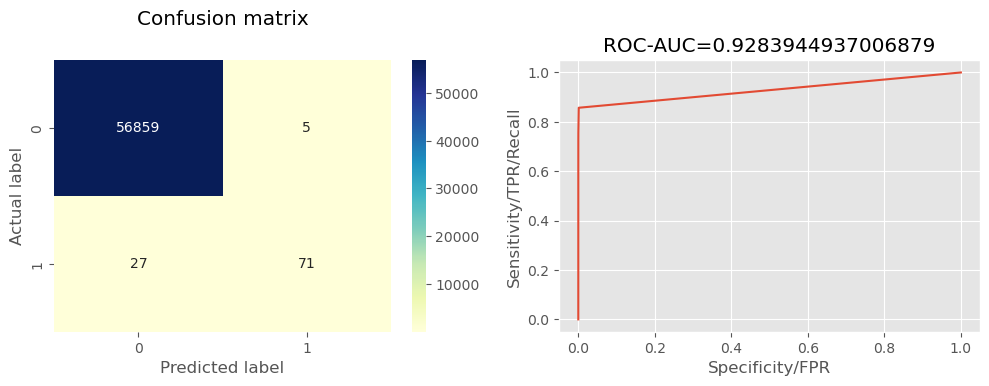

In [11]:
knn = KNeighborsClassifier()

maj = len(y_train[y_train == 0])
mino = len(y_train[y_train == 1])
frac = 0.5
num_samples = round(1/(1/frac - 1) * maj - mino)

vos = VAE_oversampling(hidden_dim=256,
                        latent_dim=20,
                        original_dim=30,
                        minority_class_id=1,
                        epochs=100,
                        batch_size=1,
                        num_samples_to_generate = num_samples,
                        random_state = 0,
                        optimizer="adam")

#Fit the VAE oversampling model and get new data set
X_res_val,y_res_val = vos.fit_sample(X_train,y_train)

std = StandardScaler()

X_train_processed = std.fit_transform(X_res_val) 
X_test_processed = std.transform(X_test)

knn.fit(X_train_processed, y_res_val)

train_predictions = knn.predict(X_train_processed)
print("################# Training Results ########################")
model_scores(y_res_val, train_predictions)

evaluate_model(X_test_processed, y_test, knn)

### One fit

Epoch 1/100
354/354 [==============================] - 2s 4ms/step - loss: 33.6678 - val_loss: 25.8653
Epoch 2/100
354/354 [==============================] - 1s 3ms/step - loss: 29.3683 - val_loss: 23.9919
Epoch 3/100
354/354 [==============================] - 1s 3ms/step - loss: 28.5344 - val_loss: 23.9801
Epoch 4/100
354/354 [==============================] - 1s 3ms/step - loss: 28.2976 - val_loss: 23.3475
Epoch 5/100
354/354 [==============================] - 1s 3ms/step - loss: 27.8588 - val_loss: 23.4060
Epoch 6/100
354/354 [==============================] - 1s 3ms/step - loss: 27.8176 - val_loss: 23.5880
Epoch 7/100
354/354 [==============================] - 1s 3ms/step - loss: 27.8209 - val_loss: 23.7741
Epoch 8/100
354/354 [==============================] - 1s 3ms/step - loss: 27.6769 - val_loss: 23.8379
Epoch 9/100
354/354 [==============================] - 1s 3ms/step - loss: 27.5351 - val_loss: 23.1233
Epoch 10/100
354/354 [==============================] - 1s 3ms/step - los

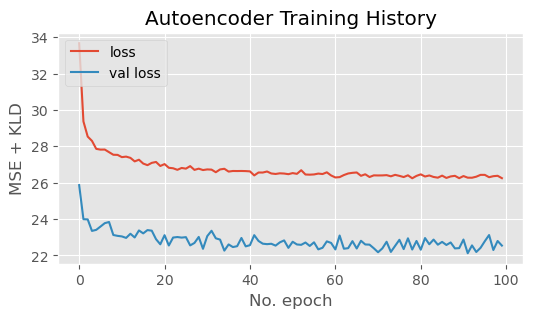

7096/7096 [==============================] - 12s 2ms/step


In [8]:
maj = len(y_train[y_train == 0])
mino = len(y_train[y_train == 1])
frac = 0.5
num_samples = round(1/(1/frac - 1) * maj - mino)

# Variational Oversampling 
vos = VAE_oversampling(hidden_dim= 64,
                        latent_dim=2,
                        original_dim=30,
                        minority_class_id=1,
                        epochs=100,
                        batch_size=1,
                        num_samples_to_generate = num_samples,
                        random_state = 0,
                        optimizer="adam")

#Fit the VAE oversampling model and get new data set
X_res_val,y_res_val = vos.fit_sample(X_train,y_train)

std = StandardScaler()

X_train_processed = std.fit_transform(X_res_val) 
X_test_processed = std.transform(X_test)

In [9]:
pd.DataFrame(X_res_val)

0         1         2         3         4         5   \
0       161919.000000  1.946747 -0.752526 -1.355130 -0.661630  1.502822   
1       124477.000000  2.035149 -0.048880 -3.058693  0.247945  2.943487   
2        41191.000000 -0.991920  0.603193  0.711976 -0.992425 -0.825838   
3       132624.000000  2.285718 -1.500239 -0.747565 -1.668119 -1.394143   
4        59359.000000 -0.448747 -1.011440  0.115903 -3.454854  0.715771   
...               ...       ...       ...       ...       ...       ...   
454897   83159.195312 -2.033702  3.589421 -2.945578  4.593170 -1.849406   
454898   82832.179688 -4.707807  7.889394 -7.068378  7.471152 -3.101629   
454899   82832.179688 -4.707792  7.892416 -7.068378  7.472758 -3.101606   
454900  110577.187500 -1.262899  3.588769 -3.635028  4.599038  0.450555   
454901  126735.679688 -0.135733  3.588730 -1.962602  4.593683  1.851425   

              6         7         8         9   ...        20        21  \
0       4.024933 -1.479661  1.139880  1.406819  ... -0.134435  0.076197   
1       3.298697 -0.002192  0.674782  0.045826  ... -0.227279  0.038628   
2       1.956261 -2.212603 -5.037523  0.000772  ...  1.280856 -2.798352   
3      -0.350339 -1.427984  0.010010 -1.118447  ... -0.490642 -0.139670   
4      -0.147490  0.504347 -0.113817 -0.044782  ... -0.275297 -0.243245   
...          ...       ...       ...       ...  ...       ...       ...   
454897 -0.684984 -1.747113  0.588279 -1.275228  ...  0.358018  0.641341   
454898 -1.387192 -5.539909  2.738250 -2.589654  ...  0.817842  0.725899   
454899 -1.387192 -5.539909  0.588240 -2.589654  ...  1.736693  0.628824   
454900 -1.372181 -2.607490  0.593148 -1.750241  ...  0.358576  0.628815   
454901 -1.247727 -0.834143  0.587994 -0.554440  ...  0.358077  0.628814   

              22        23        24        25        26        27        28  \
0       0.297537  0.307915  0.690980 -0.350316 -0.388907  0.077641 -0.032248   
1       0.228197  0.035542  0.707090  0.512885 -0.471198  0.002520 -0.069002   
2       0.109526 -0.436530 -0.932803  0.826684  0.913773  0.038049  0.185340   
3       0.077013  0.208310 -0.538236 -0.278032 -0.162068  0.018045 -0.063005   
4      -0.173298 -0.006692 -1.362383 -0.292234 -0.144622 -0.032580 -0.064194   
...          ...       ...       ...       ...       ...       ...       ...   
454897  0.051318 -0.060161 -0.109107  0.019606  0.047838  0.170788  0.096198   
454898  0.818772 -0.062790  0.350466  0.019602  0.048682  0.159445  0.077217   
454899  1.496653 -0.062790 -0.108610  0.034316  0.495890  0.995804  0.077212   
454900  0.051318 -0.062790 -0.109108  0.041252  0.074842  0.198015  0.077395   
454901  0.051318 -0.062790 -0.109108  0.033660  0.049057  0.157064  0.077213   

                29  
0         7.320000  
1         2.990000  
2       175.100000  
3         6.100000  
4        86.100000  
...            ...  
454897  267.514893  
454898  125.591469  
454899  125.591469  
454900  125.592743  
454901  125.591492  

[454902 rows x 30 columns]

In [10]:
svc_vae = SVC()

svc_vae.fit(X_train_processed, y_res_val)

#predict
pred_lr_vae_val = svc_vae.predict(X_test_processed)

model_scores(y_test, pred_lr_vae_val)

Accuracy: 0.9993504441557529
Precision: 0.8961038961038961
Recall: 0.7040816326530612
F1 score: 0.7885714285714286
ROC_AUC: 0.8519704730513478


## Oversampling with GAN

### Hyperparameter Tuning

############################### Parameters tested: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'} ################################
------------------------ KFold: 1 ---------------------------


The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 20)                620       
                                                                 
 dropout_44 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_67 (Dense)            (None, 10)                210       
                                                                 
 dropout_45 (Dropout)        (None, 10)                0         
        

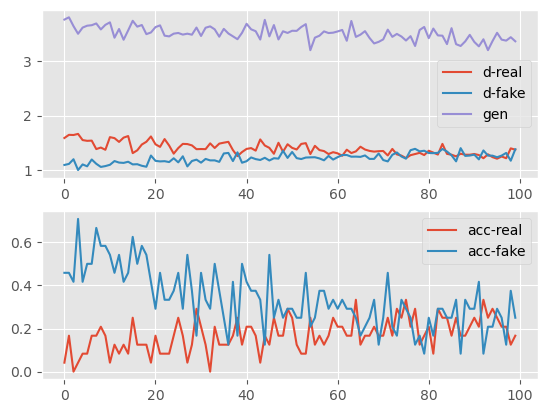

5677/5677 [==============================] - 38s 7ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 20)                620       
                                                                 
 dropout_48 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_73 (Dense)            (None, 10)                210       
                    

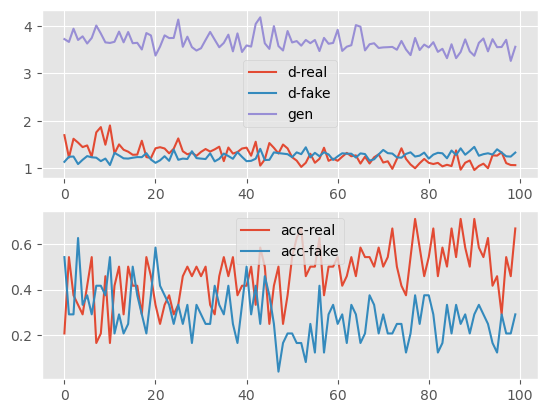

5677/5677 [==============================] - 13s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 20)                620       
                                                                 
 dropout_52 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_79 (Dense)            (None, 10)                210       
                    

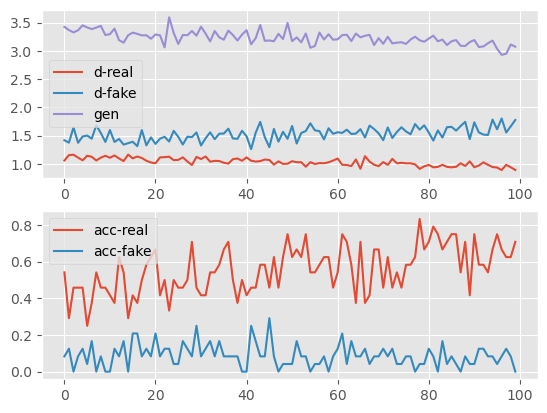

5677/5677 [==============================] - 14s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 20)                620       
                                                                 
 dropout_56 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_85 (Dense)            (None, 10)                210       
                    

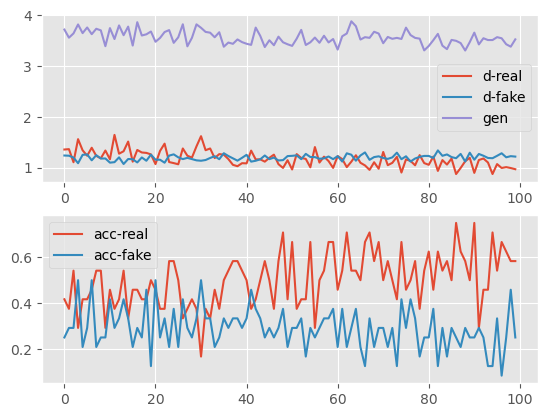

5677/5677 [==============================] - 14s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 20)                620       
                                                                 
 dropout_60 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_91 (Dense)            (None, 10)                210       
                    

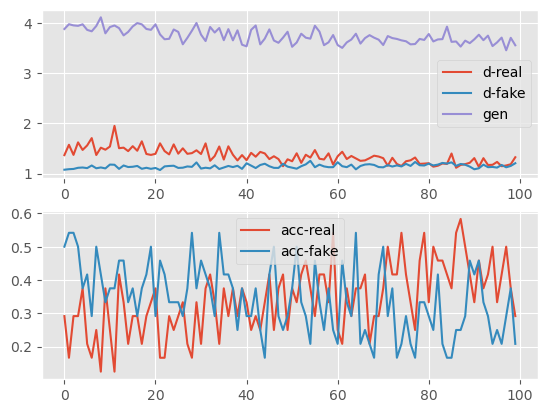

5677/5677 [==============================] - 45s 8ms/step
############################### Parameters tested: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 20)                620       
                                                                 
 dropout_64 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 20)                0         
                      

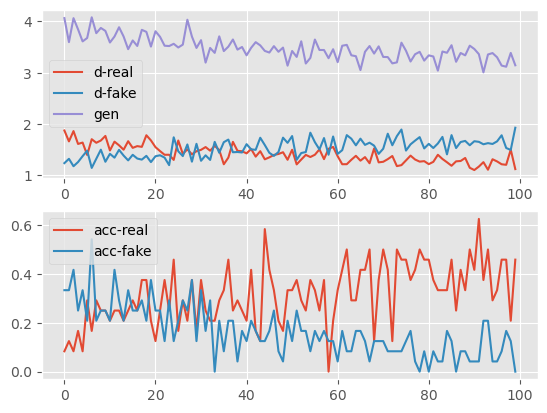

5677/5677 [==============================] - 12s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_102 (Dense)           (None, 20)                620       
                                                                 
 dropout_68 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_103 (Dense)           (None, 10)                210       
                    

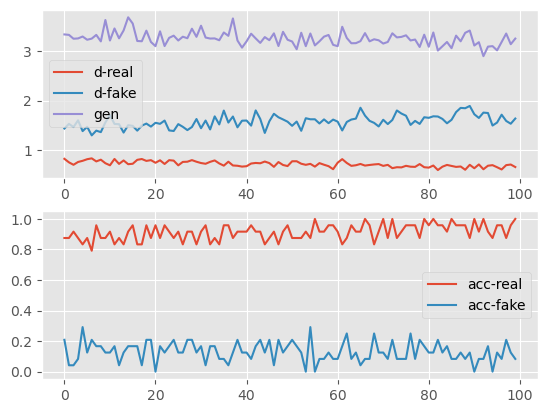

5677/5677 [==============================] - 13s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 20)                620       
                                                                 
 dropout_72 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_109 (Dense)           (None, 10)                210       
                    

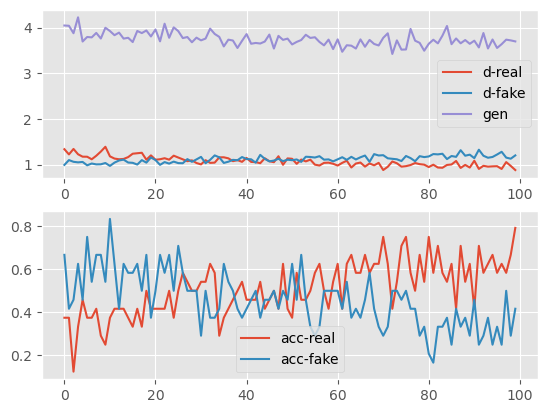

5677/5677 [==============================] - 18s 3ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_114 (Dense)           (None, 20)                620       
                                                                 
 dropout_76 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_115 (Dense)           (None, 10)                210       
                    

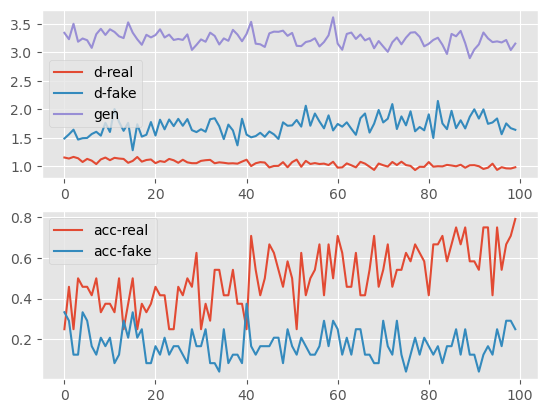

5677/5677 [==============================] - 17s 3ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 20)                620       
                                                                 
 dropout_80 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_121 (Dense)           (None, 10)                210       
                    

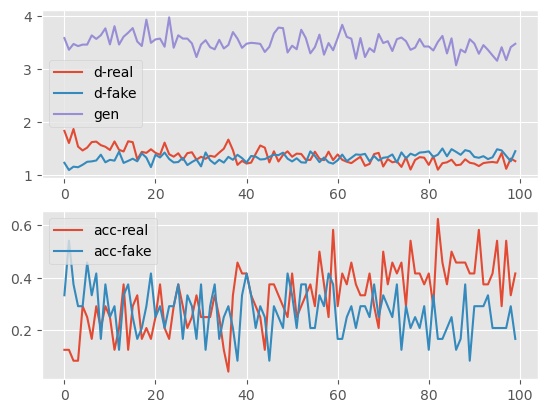

5677/5677 [==============================] - 13s 2ms/step
############################### Parameters tested: {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_126 (Dense)           (None, 20)                620       
                                                                 
 dropout_84 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_42 (LeakyReLU)  (None, 20)                0         
                    

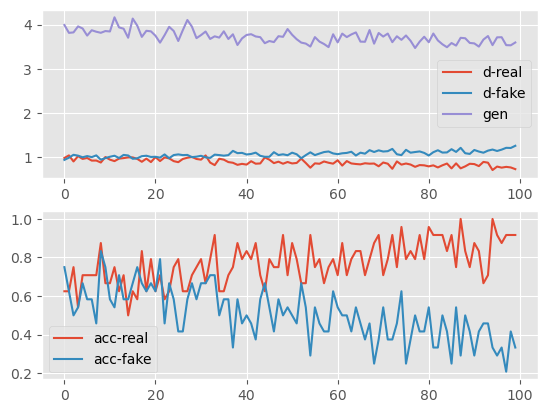

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 20)                620       
                                                                 
 dropout_88 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_44 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_133 (Dense)           (None, 10)                210       
                    

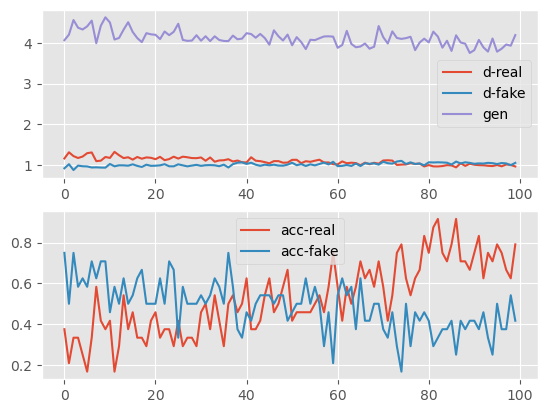

5677/5677 [==============================] - 14s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_138 (Dense)           (None, 20)                620       
                                                                 
 dropout_92 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_139 (Dense)           (None, 10)                210       
                    

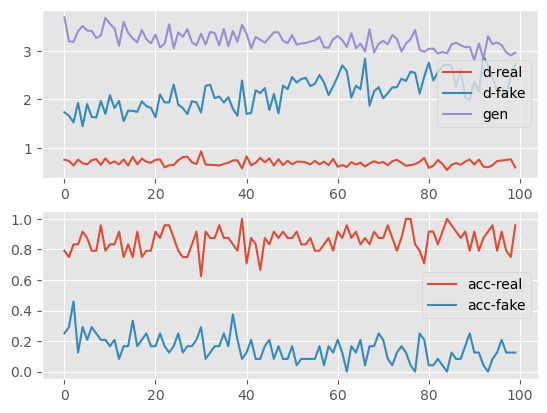

5677/5677 [==============================] - 10s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_144 (Dense)           (None, 20)                620       
                                                                 
 dropout_96 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_145 (Dense)           (None, 10)                210       
                    

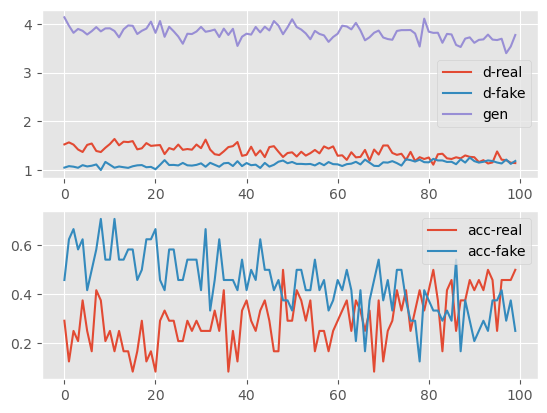

5677/5677 [==============================] - 14s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_150 (Dense)           (None, 20)                620       
                                                                 
 dropout_100 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_50 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_151 (Dense)           (None, 10)                210       
                    

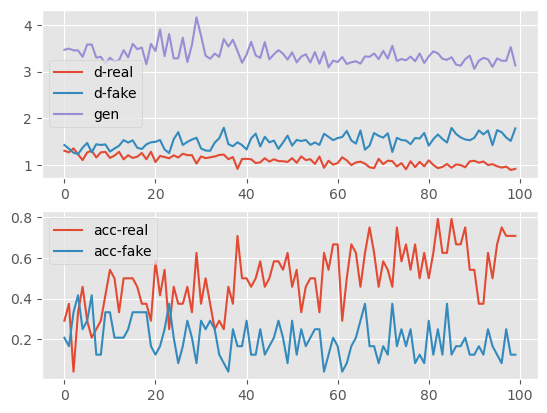

5677/5677 [==============================] - 14s 2ms/step
############################### Parameters tested: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_156 (Dense)           (None, 20)                620       
                                                                 
 dropout_104 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_52 (LeakyReLU)  (None, 20)                0         
                       

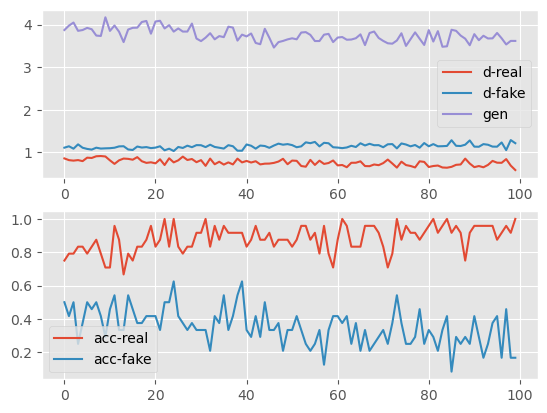

5677/5677 [==============================] - 12s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_162 (Dense)           (None, 20)                620       
                                                                 
 dropout_108 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_54 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_163 (Dense)           (None, 10)                210       
                    

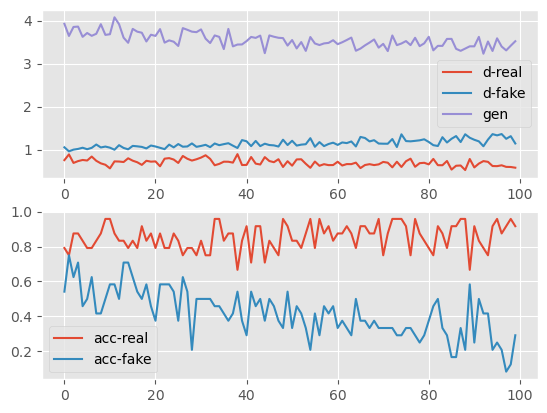

5677/5677 [==============================] - 11s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_168 (Dense)           (None, 20)                620       
                                                                 
 dropout_112 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_56 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_169 (Dense)           (None, 10)                210       
                    

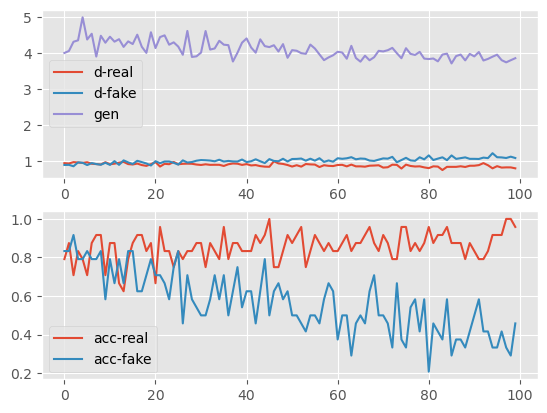

5677/5677 [==============================] - 13s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_174 (Dense)           (None, 20)                620       
                                                                 
 dropout_116 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_58 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_175 (Dense)           (None, 10)                210       
                    

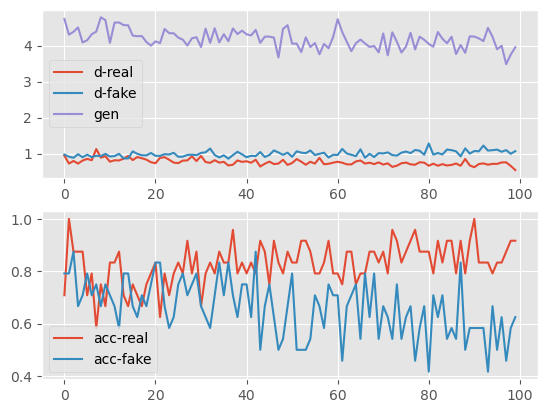

5677/5677 [==============================] - 14s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_180 (Dense)           (None, 20)                620       
                                                                 
 dropout_120 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_60 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_181 (Dense)           (None, 10)                210       
                    

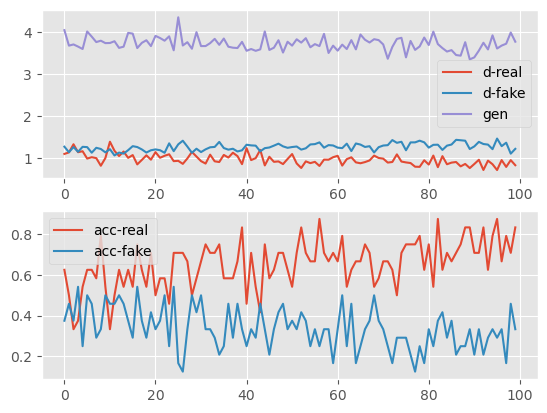

5677/5677 [==============================] - 12s 2ms/step
############################### Parameters tested: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_186 (Dense)           (None, 20)                620       
                                                                 
 dropout_124 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_62 (LeakyReLU)  (None, 20)                0         
                     

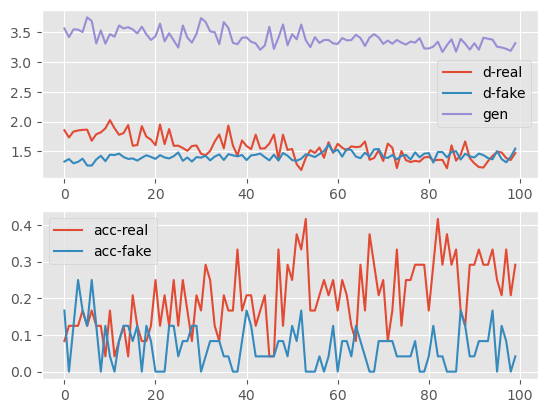

5677/5677 [==============================] - 17s 3ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_192 (Dense)           (None, 20)                620       
                                                                 
 dropout_128 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_64 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_193 (Dense)           (None, 10)                210       
                    

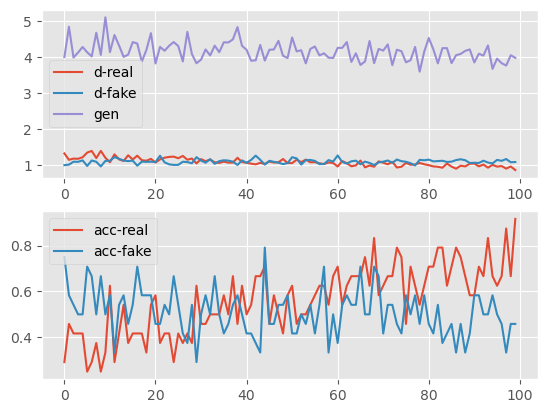

5677/5677 [==============================] - 13s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_198 (Dense)           (None, 20)                620       
                                                                 
 dropout_132 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_66 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_199 (Dense)           (None, 10)                210       
                    

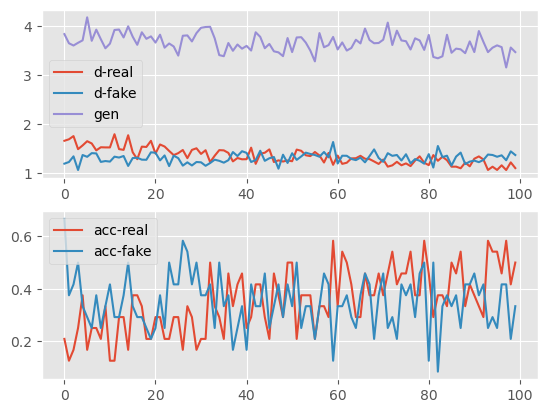

5677/5677 [==============================] - 14s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_204 (Dense)           (None, 20)                620       
                                                                 
 dropout_136 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_68 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_205 (Dense)           (None, 10)                210       
                   

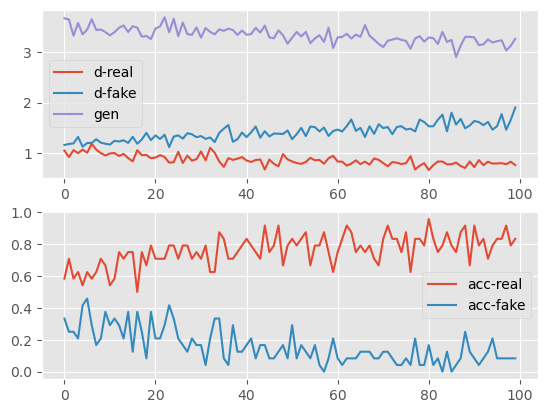

5677/5677 [==============================] - 13s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_105"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_210 (Dense)           (None, 20)                620       
                                                                 
 dropout_140 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_70 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_211 (Dense)           (None, 10)                210       
                   

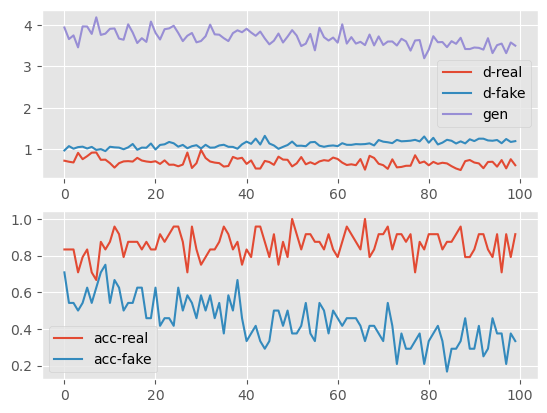

5677/5677 [==============================] - 16s 3ms/step
############################### Parameters tested: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Model: "sequential_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_216 (Dense)           (None, 20)                620       
                                                                 
 dropout_144 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_72 (LeakyReLU)  (None, 20)                0         
                       

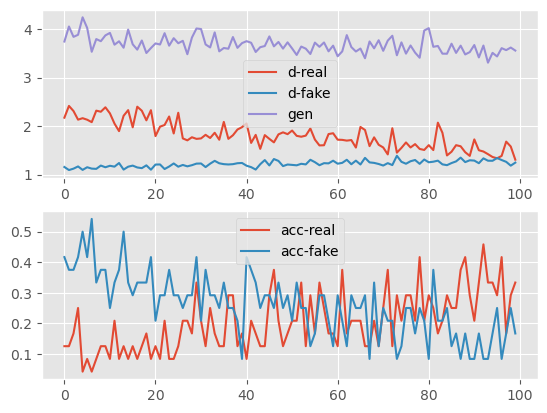

5677/5677 [==============================] - 12s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_111"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_222 (Dense)           (None, 20)                620       
                                                                 
 dropout_148 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_74 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_223 (Dense)           (None, 10)                210       
                   

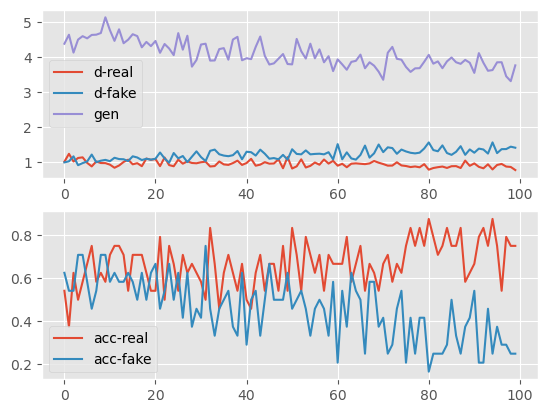

5677/5677 [==============================] - 18s 3ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_114"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_228 (Dense)           (None, 20)                620       
                                                                 
 dropout_152 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_76 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_229 (Dense)           (None, 10)                210       
                   

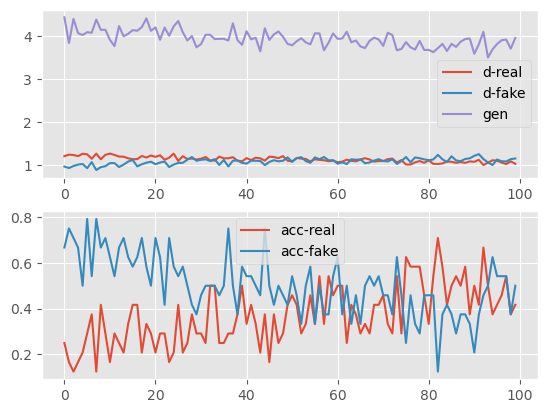

5677/5677 [==============================] - 13s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_117"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_234 (Dense)           (None, 20)                620       
                                                                 
 dropout_156 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_78 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_235 (Dense)           (None, 10)                210       
                   

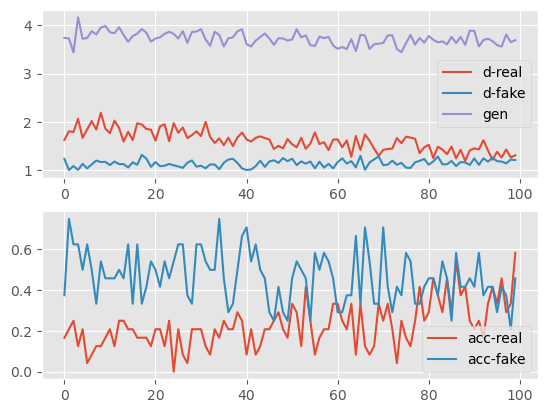

5677/5677 [==============================] - 15s 3ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_240 (Dense)           (None, 20)                620       
                                                                 
 dropout_160 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_80 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_241 (Dense)           (None, 10)                210       
                   

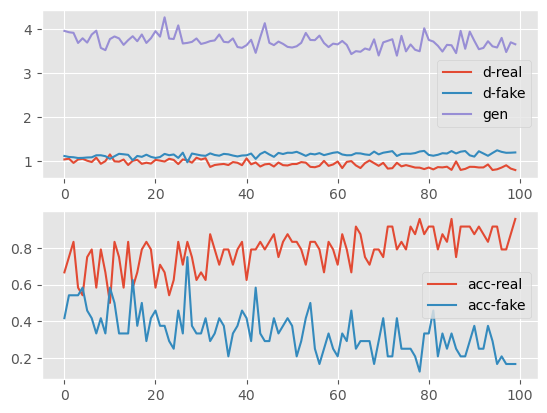

5677/5677 [==============================] - 17s 3ms/step
############################### Parameters tested: {'C': 1, 'gamma': 'auto', 'kernel': 'linear'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Model: "sequential_123"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_246 (Dense)           (None, 20)                620       
                                                                 
 dropout_164 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_82 (LeakyReLU)  (None, 20)                0         
                     

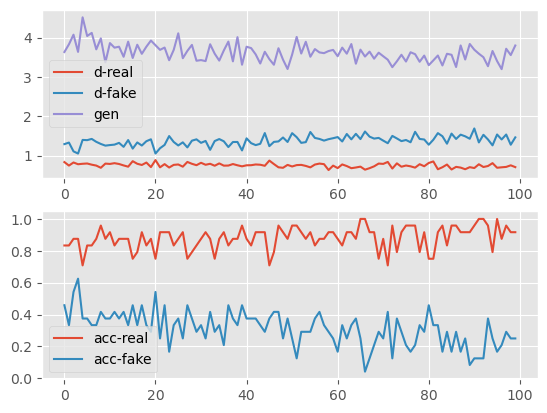

5677/5677 [==============================] - 14s 2ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_252 (Dense)           (None, 20)                620       
                                                                 
 dropout_168 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_84 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_253 (Dense)           (None, 10)                210       
                   

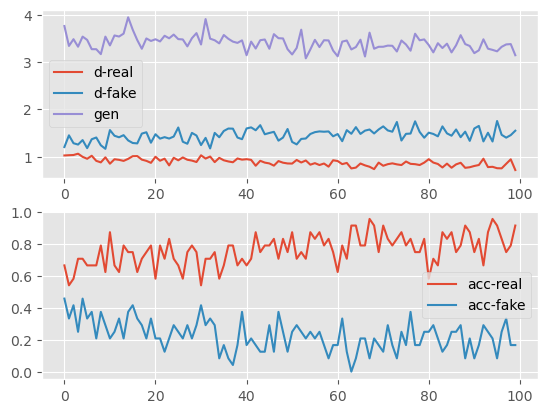

5677/5677 [==============================] - 12s 2ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_129"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_258 (Dense)           (None, 20)                620       
                                                                 
 dropout_172 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_86 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_259 (Dense)           (None, 10)                210       
                   

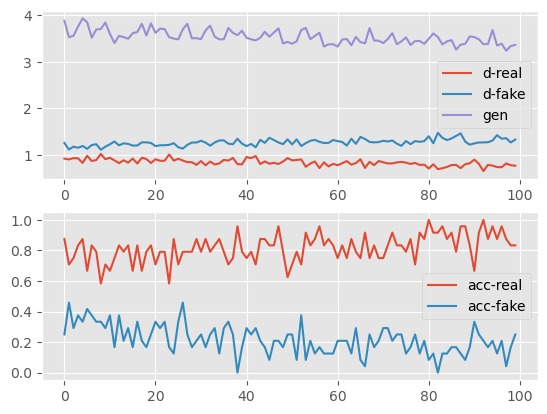

5677/5677 [==============================] - 14s 2ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_132"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_264 (Dense)           (None, 20)                620       
                                                                 
 dropout_176 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_88 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_265 (Dense)           (None, 10)                210       
                   

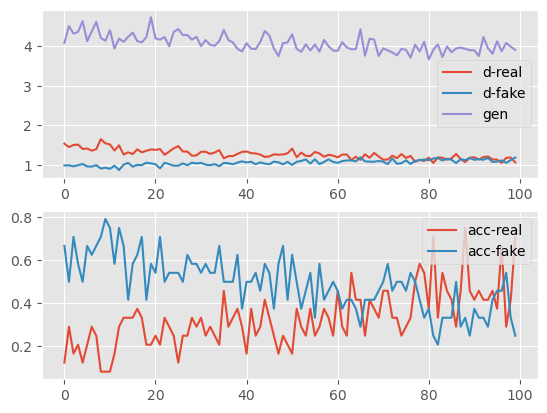

5677/5677 [==============================] - 13s 2ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_270 (Dense)           (None, 20)                620       
                                                                 
 dropout_180 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_90 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_271 (Dense)           (None, 10)                210       
                   

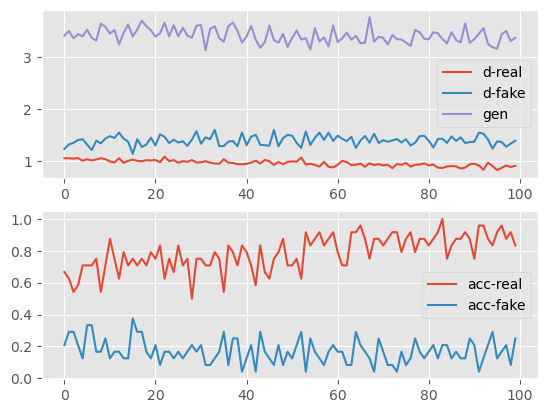

5677/5677 [==============================] - 14s 2ms/step
############################### Parameters tested: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'} ################################
------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
Number of samples to be generated:  181644
Model: "sequential_138"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_276 (Dense)           (None, 20)                620       
                                                                 
 dropout_184 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_92 (LeakyReLU)  (None, 20)                0         
                        

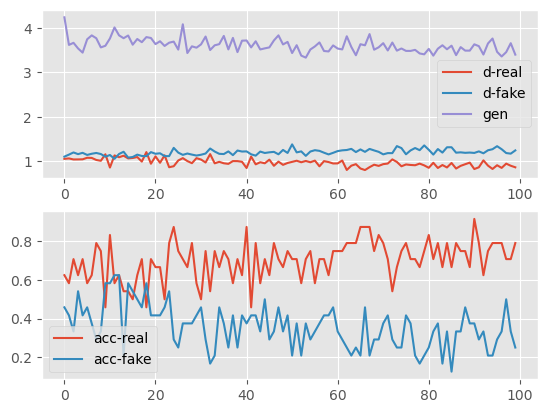

5677/5677 [==============================] - 18s 3ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_141"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_282 (Dense)           (None, 20)                620       
                                                                 
 dropout_188 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_94 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_283 (Dense)           (None, 10)                210       
                   

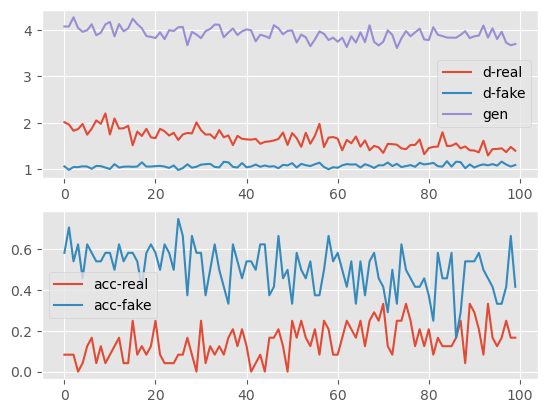

5677/5677 [==============================] - 18s 3ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_144"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_288 (Dense)           (None, 20)                620       
                                                                 
 dropout_192 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_96 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_289 (Dense)           (None, 10)                210       
                   

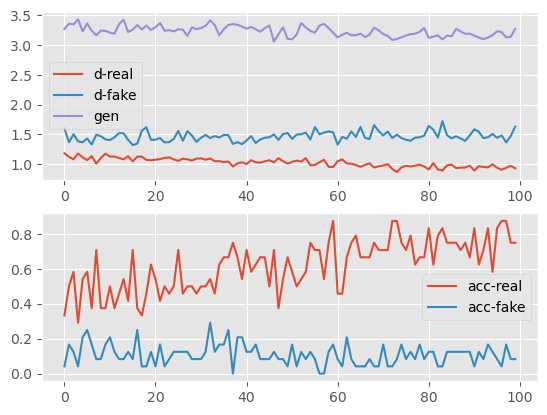

5677/5677 [==============================] - 15s 3ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_147"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_294 (Dense)           (None, 20)                620       
                                                                 
 dropout_196 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_98 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_295 (Dense)           (None, 10)                210       
                   

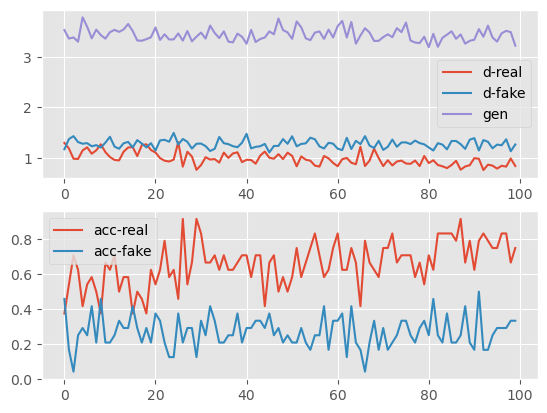

5677/5677 [==============================] - 15s 3ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
Number of samples to be generated:  181646
Model: "sequential_150"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_300 (Dense)           (None, 20)                620       
                                                                 
 dropout_200 (Dropout)       (None, 20)                0         
                                                                 
 leaky_re_lu_100 (LeakyReLU)  (None, 20)               0         
                                                                 
 dense_301 (Dense)           (None, 10)                210       
                   

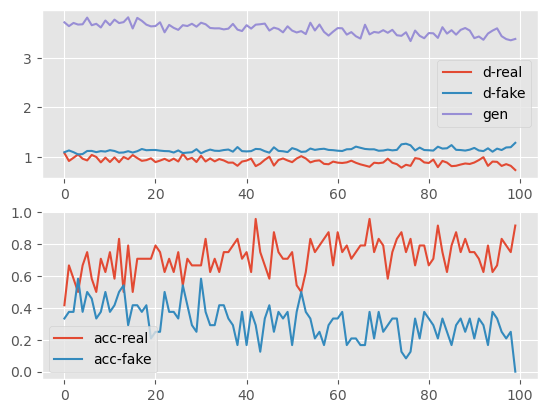

5677/5677 [==============================] - 15s 3ms/step


<Figure size 640x480 with 0 Axes>

In [13]:
#With hyperparameter tuning
#Cross validation
skf = StratifiedKFold(n_splits=5)

# Define the hyperparameters to tune
param_grid = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize variables to store the best hyperparameters and AUC score
best_params = {}
best_scores = []
best_f1 = -np.inf

# Iterate over all combinations of hyperparameters
for params in ParameterGrid(param_grid):
    lst_accuracy = []
    lst_precision = []
    lst_recall = []
    lst_f1_score = []
    lst_roc_auc_score = []
    
    f1_scores = []

    model = SVC(C=params['C'], kernel=params['kernel'], gamma=params['gamma'])

    print("############################### Parameters tested:", params,"################################")
    for count, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
        print("------------------------ KFold:", count+1, "---------------------------")
        X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

        print(f"The training dataset has {sorted(Counter(y_train_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_train_fold).items())[1][1]} records for the minority class.")
        print(f"The test dataset has {sorted(Counter(y_valid_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_valid_fold).items())[1][1]} records for the minority class.")
        
        maj = len(y_train_fold[y_train_fold == 0])
        mino = len(y_train_fold[y_train_fold == 1])
        frac = 0.5
        num_samples = round(1/(1/frac - 1) * maj - mino)

        print("Number of samples to be generated: ", num_samples)

        gan = GAN(input_dim= 30, 
              generator_output_dim=30, 
              discriminator_input_dim=30,
              noise_dim=100,
              num_samples=num_samples, 
              epochs=100, 
              batch_size=24,
              dropout=0.4)

        #Fit the GAN oversampling model and get new data set
        X_res_val_gan,y_res_val_gan = gan.fit_sample(X_train_fold, y_train_fold)

        std = StandardScaler()
        
        X_train_processed = std.fit_transform(X_res_val_gan) 
        X_valid_processed = std.transform(X_valid_fold)

        model.fit(X_train_processed, y_res_val_gan)

        y_pred_test = model.predict(X_valid_processed)

        lst_accuracy.append(accuracy_score(y_valid_fold, y_pred_test))
        lst_precision.append(precision_score(y_valid_fold, y_pred_test))
        lst_recall.append(recall_score(y_valid_fold, y_pred_test))
        lst_f1_score.append(f1_score(y_valid_fold, y_pred_test))
        lst_roc_auc_score.append(roc_auc_score(y_valid_fold, y_pred_test))


    avg_f1 = np.mean(lst_f1_score)

    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_scores = [lst_accuracy, lst_precision, lst_recall, lst_f1_score, lst_roc_auc_score]
        best_params = params


In [14]:
# Print the best AUC score and hyperparameters
print(f"Accuracy:, {np.mean(best_scores[0]):0.6f} (+/- {np.std(best_scores[0]):0.6f})")
print(f"Precision: {np.mean(best_scores[1]):0.6f} (+/- {np.std(best_scores[1]):0.6f})")
print(f"Recall: {np.mean(best_scores[2]):0.6f} (+/- {np.std(best_scores[2]):0.6f})")
print(f"F1 score: {np.mean(best_scores[3]):0.6f} (+/- {np.std(best_scores[3]):0.6f})")
print(f"ROC_AUC: {np.mean(best_scores[4]):0.6f} (+/- {np.std(best_scores[4]):0.6f})")
print("Best hyperparameters:", best_params)

Accuracy:, 0.999399 (+/- 0.000022)
Precision: 0.847475 (+/- 0.018577)
Recall: 0.796819 (+/- 0.033059)
F1 score: 0.820587 (+/- 0.011399)
ROC_AUC: 0.898284 (+/- 0.016509)
Best hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


### Cross Validation

------------------------ KFold: 1 ---------------------------
The training dataset has 181960 records for the majority class and 316 records for the minority class.
The test dataset has 45491 records for the majority class and 78 records for the minority class.
NUmber of samples to be generated:  181644
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 30)                108636    
                                                                 
 sequential (Sequential)     (None, 1)                 841       
                                                                 
Total params: 109,477
Trainable params: 108,636
Non-trainable params: 841
_________________________________________________________________
1/1 [==============================] - 0s 346ms/step
1 [D loss: 1.120620, acc.: 54.17%] [G loss: 4.760582]
1/1 [=========================

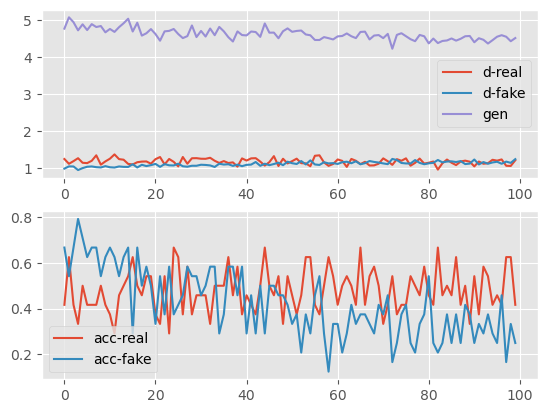

5677/5677 [==============================] - 18s 3ms/step
------------------------ KFold: 2 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 30)                108636    
                                                                 
 sequential_3 (Sequential)   (None, 1)                 841       
                                                                 
Total params: 109,477
Trainable params: 108,636
Non-trainable params: 841
_________________________________________________________________
1/1 [==============================] - 0s 464ms/step
1 [D loss: 1.157241, acc.:

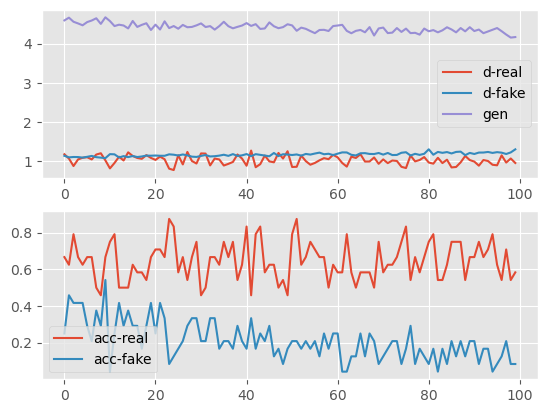

5677/5677 [==============================] - 31s 5ms/step
------------------------ KFold: 3 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 30)                108636    
                                                                 
 sequential_6 (Sequential)   (None, 1)                 841       
                                                                 
Total params: 109,477
Trainable params: 108,636
Non-trainable params: 841
_________________________________________________________________
1/1 [==============================] - 1s 1s/step
1 [D loss: 1.684248, acc.: 37

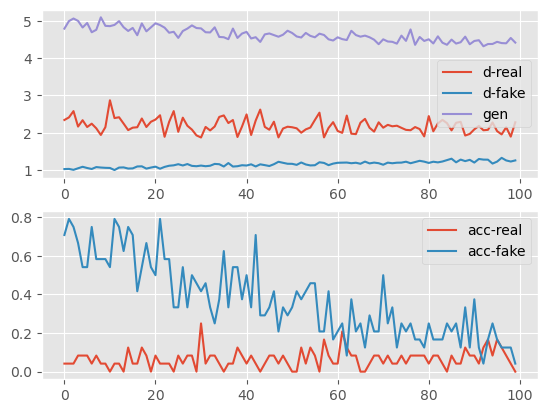

5677/5677 [==============================] - 83s 15ms/step
------------------------ KFold: 4 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 30)                108636    
                                                                 
 sequential_9 (Sequential)   (None, 1)                 841       
                                                                 
Total params: 109,477
Trainable params: 108,636
Non-trainable params: 841
_________________________________________________________________
1/1 [==============================] - 1s 949ms/step
1 [D loss: 0.845904, acc

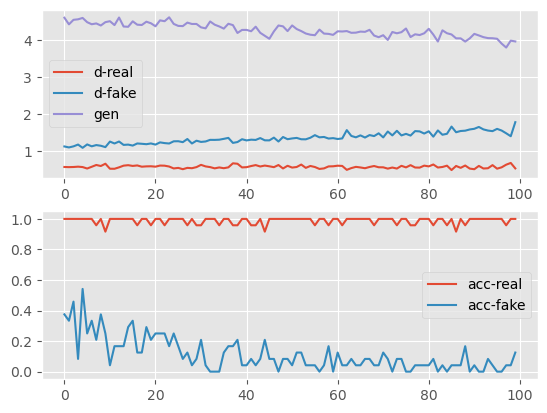

5677/5677 [==============================] - 78s 14ms/step
------------------------ KFold: 5 ---------------------------
The training dataset has 181961 records for the majority class and 315 records for the minority class.
The test dataset has 45490 records for the majority class and 79 records for the minority class.
NUmber of samples to be generated:  181646
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_13 (Sequential)  (None, 30)                108636    
                                                                 
 sequential_12 (Sequential)  (None, 1)                 841       
                                                                 
Total params: 109,477
Trainable params: 108,636
Non-trainable params: 841
_________________________________________________________________
1/1 [==============================] - 0s 487ms/step
1 [D loss: 1.253444, acc

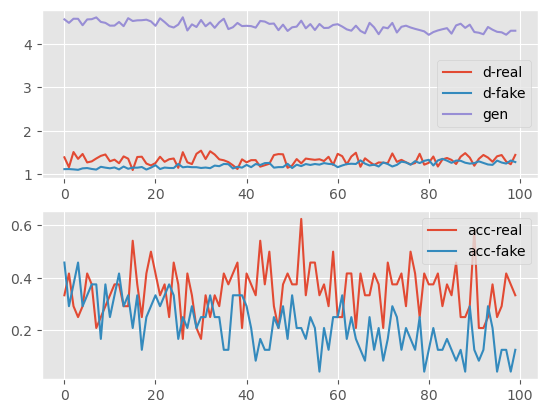

5677/5677 [==============================] - 76s 13ms/step


In [6]:
#Cross validation
skf = StratifiedKFold(n_splits=5)
lst_accuracy = []
lst_precision = []
lst_recall = []
lst_f1_score = []
lst_roc_auc_score = []

lst_accuracy_train = []
lst_precision_train = []
lst_recall_train = []
lst_f1_score_train = []
lst_roc_auc_score_train = []

model = KNeighborsClassifier()

for count, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
    print("------------------------ KFold:", count+1, "---------------------------")
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]

    print(f"The training dataset has {sorted(Counter(y_train_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_train_fold).items())[1][1]} records for the minority class.")
    print(f"The test dataset has {sorted(Counter(y_valid_fold).items())[0][1]} records for the majority class and {sorted(Counter(y_valid_fold).items())[1][1]} records for the minority class.")
    
    maj = len(y_train_fold[y_train_fold == 0])
    mino = len(y_train_fold[y_train_fold == 1])
    frac = 0.5
    num_samples = round(1/(1/frac - 1) * maj - mino)

    print("NUmber of samples to be generated: ", num_samples)
    
    gan = GAN(generator_output_dim=30, 
              discriminator_input_dim=30,
              noise_dim=50,
              num_samples=num_samples, 
              epochs=100, 
              batch_size=24,
              dropout=0.4)

    #Fit the GAN oversampling model and get new data set
    X_res_val_gan,y_res_val_gan = gan.fit_sample(X_train_fold, y_train_fold)

    std = StandardScaler()
    
    X_train_processed = std.fit_transform(X_res_val_gan) 
    X_valid_processed = std.transform(X_valid_fold)

    model.fit(X_train_processed, y_res_val_gan)

    train_predictions = model.predict(X_train_processed)
    
    y_pred_test = model.predict(X_valid_processed)

    lst_accuracy.append(accuracy_score(y_valid_fold, y_pred_test))
    lst_precision.append(precision_score(y_valid_fold, y_pred_test))
    lst_recall.append(recall_score(y_valid_fold, y_pred_test))
    lst_f1_score.append(f1_score(y_valid_fold, y_pred_test))
    lst_roc_auc_score.append(roc_auc_score(y_valid_fold, y_pred_test))

    lst_accuracy_train.append(accuracy_score(y_res_val_gan, train_predictions))
    lst_precision_train.append(precision_score(y_res_val_gan, train_predictions))
    lst_recall_train.append(recall_score(y_res_val_gan, train_predictions))
    lst_f1_score_train.append(f1_score(y_res_val_gan, train_predictions))
    lst_roc_auc_score_train.append(roc_auc_score(y_res_val_gan, train_predictions))



In [7]:
print('############ Validation #############')
print(f"Accuracy:, {np.mean(lst_accuracy):0.6f} (+/- {np.std(lst_accuracy):0.6f})")
print(f"Precision: {np.mean(lst_precision):0.6f} (+/- {np.std(lst_precision):0.6f})")
print(f"Recall: {np.mean(lst_recall):0.6f} (+/- {np.std(lst_recall):0.6f})")
print(f"F1 score: {np.mean(lst_f1_score):0.6f} (+/- {np.std(lst_f1_score):0.6f})")
print(f"ROC_AUC: {np.mean(lst_roc_auc_score):0.6f} (+/- {np.std(lst_roc_auc_score):0.6f})")

print('############ Training #############')
print(f"Accuracy:, {np.mean(lst_accuracy_train):0.6f} (+/- {np.std(lst_accuracy_train):0.6f})")
print(f"Precision: {np.mean(lst_precision_train):0.6f} (+/- {np.std(lst_precision_train):0.6f})")
print(f"Recall: {np.mean(lst_recall_train):0.6f} (+/- {np.std(lst_recall_train):0.6f})")
print(f"F1 score: {np.mean(lst_f1_score_train):0.6f} (+/- {np.std(lst_f1_score_train):0.6f})")
print(f"ROC_AUC: {np.mean(lst_roc_auc_score_train):0.6f} (+/- {np.std(lst_roc_auc_score_train):0.6f})")

############ Validation #############
Accuracy:, 0.999320 (+/- 0.000054)
Precision: 0.932925 (+/- 0.024602)
Recall: 0.654625 (+/- 0.040763)
F1 score: 0.768180 (+/- 0.026025)
ROC_AUC: 0.827271 (+/- 0.020371)
############ Training #############
Accuracy:, 0.999703 (+/- 0.000009)
Precision: 0.999944 (+/- 0.000015)
Recall: 0.999463 (+/- 0.000027)
F1 score: 0.999703 (+/- 0.000009)
ROC_AUC: 0.999703 (+/- 0.000009)


In [ ]:
lr = KNeighborsClassifier()

maj = len(y_train[y_train == 0])
mino = len(y_train[y_train == 1])
frac = 0.5
num_samples = round(1/(1/frac - 1) * maj - mino)

gan = GAN(generator_output_dim=30, 
              discriminator_input_dim=30,
              noise_dim=50,
              num_samples=num_samples, 
              epochs=100, 
              batch_size=24,
              dropout=0.4)


X_res_val_gan,y_res_val_gan = gan.fit_sample(X_train, y_train)

std = StandardScaler()
    
X_train_processed = std.fit_transform(X_res_val_gan) 
X_test_processed = std.transform(X_test)

lr.fit(X_train_processed, y_res_val_gan)

train_predictions = lr.predict(X_train_processed)
print("################# Training Results ########################")
model_scores(y_res_val_gan, train_predictions)

evaluate_model(X_test_processed, y_test, lr)

### One fit

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 20)                620       
                                                                 
 dropout_20 (Dropout)        (None, 20)                0         
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 20)                0         
                                                                 
 dense_31 (Dense)            (None, 10)                210       
                                                                 
 dropout_21 (Dropout)        (None, 10)                0         
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 10)                0         
                                                                 
 dense_32 (Dense)            (None, 1)               

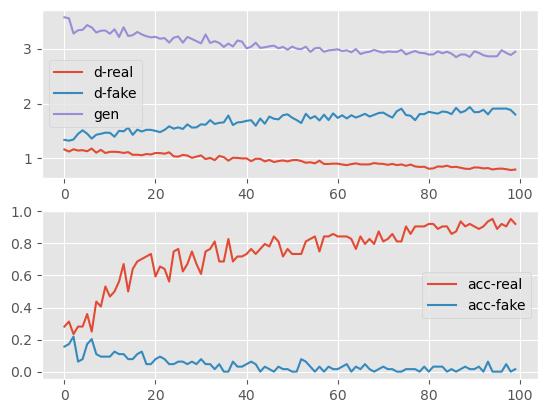

7096/7096 [==============================] - 15s 2ms/step


<Figure size 640x480 with 0 Axes>

In [8]:
maj = len(y_train[y_train == 0])
mino = len(y_train[y_train == 1])
frac = 0.5
num_samples = round(1/(1/frac - 1) * maj - mino)

gan = GAN(input_dim= 30, 
            generator_output_dim=30, 
            discriminator_input_dim=30,
            noise_dim=100,
            num_samples=num_samples, 
            epochs=100, 
            batch_size=64,
            dropout=0.1)

#Fit the GAN oversampling model and get new data set
X_res_val_gan,y_res_val_gan = gan.fit_sample(X_train, y_train)

std = StandardScaler()

X_train_processed_gan = std.fit_transform(X_res_val_gan)
X_test_processed_gan = std.transform(X_test)

In [9]:
logReg_vae = SVC()

logReg_vae.fit(X_train_processed_gan, y_res_val_gan)

#predict
pred_lr_vae_val = logReg_vae.predict(X_test_processed_gan)

model_scores(y_test, pred_lr_vae_val)

Accuracy: 0.9994382219725431
Precision: 0.9125
Recall: 0.7448979591836735
F1 score: 0.8202247191011237
ROC_AUC: 0.8723874292260517
